In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
#import openfermion as of
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
#import covvqetools as cov

plt.rcParams.update({
  "text.usetex": True,
  #"font.family": "Helvetica"
})

notebook_path = os.path.dirname(os.path.realpath("__file__"))
#data_dir1 = notebook_path+'/optimizer_plot_data/optimizer_many_gens/rg_nact6/'
print(notebook_path)
data_dir1 = notebook_path+'/mainz_device_benchmarking'

data10 = pd.read_json(data_dir1+'/all_data.json')

C:\Users\fgkri\Coding\PhD_notebooks\PhD_notebooks\Mainz_data


C:\Users\fgkri\AppData\Local\Temp\ipykernel_2812\3663079359.py:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=xs, y=ys, marker=markers_dict[layer], label=f'Qubits: {qb}, layer:{layer}', c=color)


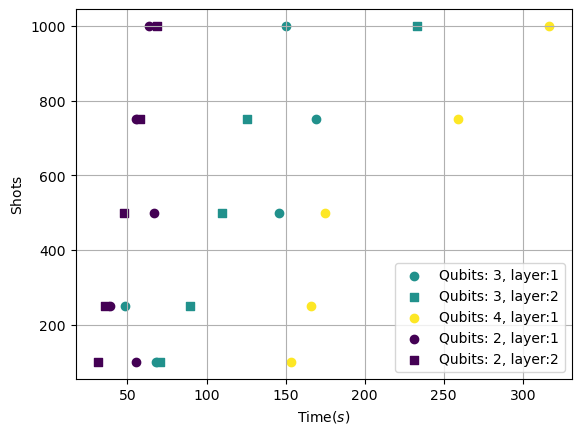

In [7]:
plt.rcParams.update({
  "text.usetex": False,
  #"font.family": "Helvetica"
})
markers_dict = {1: 'o', 2: 's', 3: '^'}
cmap = plt.get_cmap('viridis')

for qb in data10.nqubits.unique():
    qb_filt=data10[data10['nqubits']==qb]
    norm = plt.Normalize(data10['nqubits'].min(), data10['nqubits'].max())
    color = cmap(norm(qb))  # Map qubit value to a color using the colormap
    for layer in qb_filt.layers.unique():
        layer_filt=qb_filt[qb_filt['layers']==layer]

        xs=layer_filt.time_elapsed
        ys=layer_filt.shots
        
        plt.scatter(x=xs, y=ys, marker=markers_dict[layer], label=f'Qubits: {qb}, layer:{layer}', c=color)
plt.ylabel(r'$\text{Shots}$')
plt.xlabel(r'$\text{Time}(s)$')
plt.legend()
plt.grid(True)
plt.savefig('mainz_dev_time_cost_benchmarking.pdf')
plt.show()

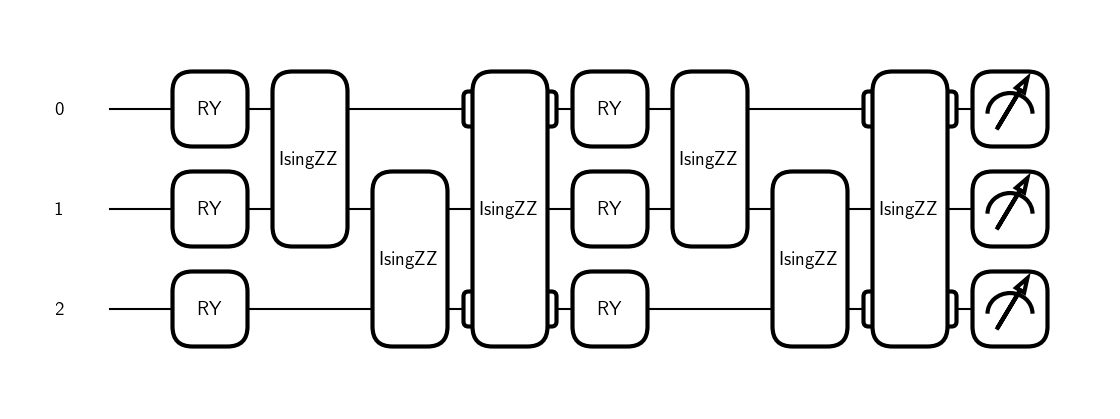

In [153]:
import pennylane as qml
import numpy as np
nqubits=3
layers=2
shots=1000
dev = qml.device('default.qubit', shots=shots, wires=nqubits)
@qml.qnode(dev)
def ansatz_for_mainz(params):
    for layer in range(layers):
        for wire in dev.wires:
            qml.RY(params[wire][layer], wires=wire)
        for wire in dev.wires:
            qml.IsingZZ(np.pi/2, wires=[wire, (wire+1)%nqubits])

    return [qml.expval(qml.PauliZ(wires=wire)) for wire in range(nqubits)]

init_params = np.random.rand(nqubits, layers)
#fig, ax object tuple
fig0, ax0 =qml.draw_mpl(ansatz_for_mainz)(init_params)
#fig0.savefig('mainz_benchmarking_circuit.pdf')


## Phase functions of expectation values in different VQE parameters (3 qubit circuit)

In [64]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
#import openfermion as of
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
#import covvqetools as cov

plt.rcParams.update({
  "text.usetex": True,
  #"font.family": "Helvetica"
})

notebook_path = os.path.dirname(os.path.realpath("__file__"))

#data_dir1 = notebook_path+'/optimizer_plot_data/optimizer_many_gens/rg_nact6/'
# vpe_data_path = notebook_path+'/mainz_cost_model/vpe_experimental_data/data_caching_v39/'
#vpe_data_path = notebook_path+'/mainz_cost_model/vpe_experimental_data/redtrap_many_shots_v52_compile_optim_off/system_size_3'
#vpe_data_path = notebook_path+'/mainz_cost_model/vpe_experimental_data/redtrap_many_shots_v11/system_size_3'

#vpe_data_path = notebook_path+'/mainz_cost_model/vpe_experimental_data/data_caching_v47_redtrap_2000shots/'
#vpe_data_path = notebook_path+'/mainz_cost_model/vpe_experimental_data/dirichlet_mirroring_v1/'

vpe_data_path_3qb = notebook_path+'/mainz_phase_fn_data/redtrap_many_shots_v20_size3_compilation_opt_on/system_size_3'
#vpe_data_path = notebook_path+'/mainz_phase_fn_data/redtrap_many_shots_v25_size2_opt_on/system_size_2'

vpe_data_3qb = pd.read_json(vpe_data_path_3qb+'/all_data.json')

In [65]:
unique_params_3qb=[]
unique_obs_3qb=vpe_data_3qb.observable.dropna().unique()
for item in vpe_data_3qb.parameter.dropna().items():
    if item[1] not in unique_params_3qb:
        unique_params_3qb.append(item[1])
print("Unique parameters: \n", unique_params_3qb)
print("Unique observables: \n", unique_obs_3qb)

Unique parameters: 
 [[-9.4247779608, 4.1908845999], [-6.2831853072, 2.7939230666], [-3.1415926536, 1.3969615333], [0.0, 0.0], [3.1415926536, -1.3969615333], [6.2831853072, -2.7939230666], [9.4247779608, -4.1908845999]]
Unique observables: 
 ['1.0 [Z0 Z1]' '1.0 [Z0]']


In [66]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# adc=vpe_data[vpe_data['device_shots'].notna()]
# adc_nops=adc[adc['cached_value_str']=='expvalYphased_nops']
# adc_ps=adc[adc['cached_value_str']=='expvalYphased_ps']


# adc_nops['usable_values']=adc_nops['cached_value']*adc_nops['cached_shots']/500
# adc_ps['usable_values']=adc_ps['cached_value']*adc_ps['cached_shots']/500

# adc_nops

[-9.4247779608, 4.1908845999]
{'1.0 [Z0 Z1]': 0.64, '1.0 [Z0]': 0.7}


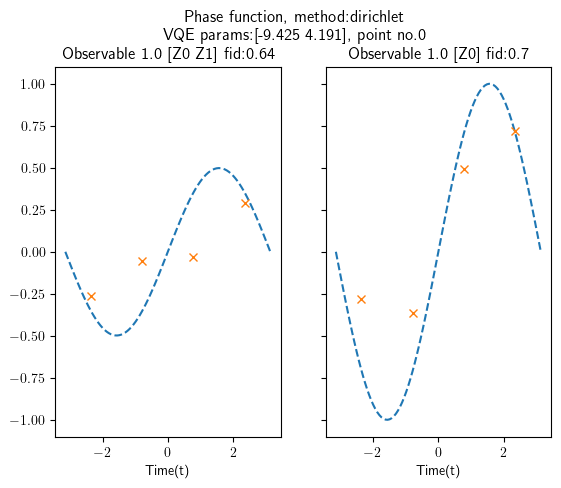

{'1.0 [Z0 Z1]': 0.623, '1.0 [Z0]': 0.679}


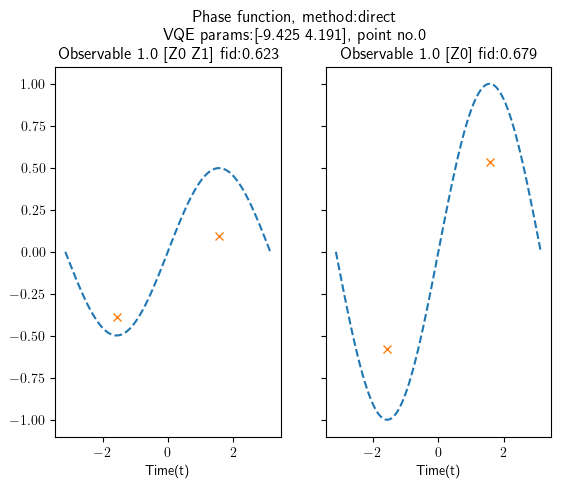

[-6.2831853072, 2.7939230666]
{'1.0 [Z0 Z1]': 0.562, '1.0 [Z0]': 0.675}


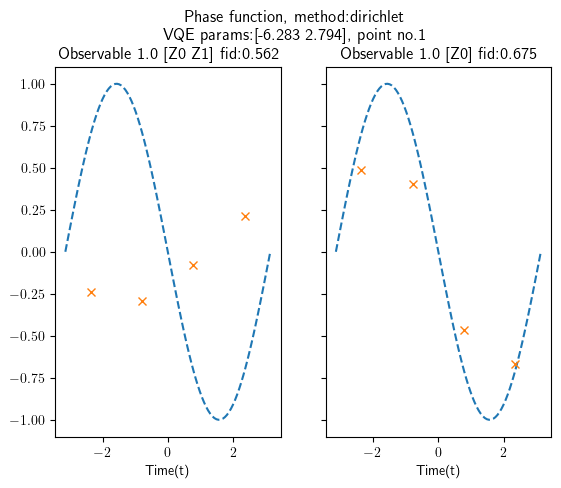

{'1.0 [Z0 Z1]': 0.505, '1.0 [Z0]': 0.514}


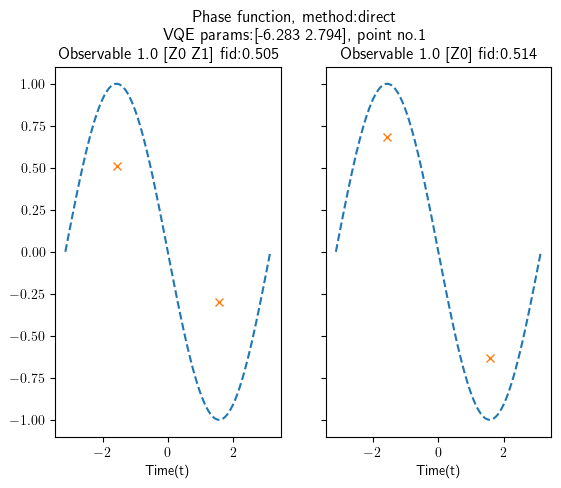

[-3.1415926536, 1.3969615333]
{'1.0 [Z0 Z1]': 0.64, '1.0 [Z0]': 0.605}


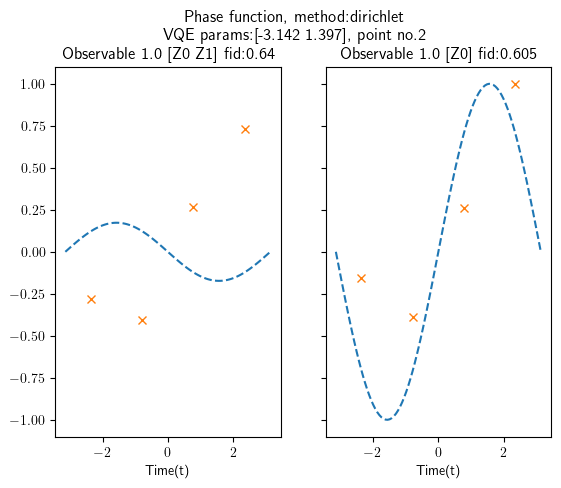

{'1.0 [Z0 Z1]': 0.644, '1.0 [Z0]': 0.64}


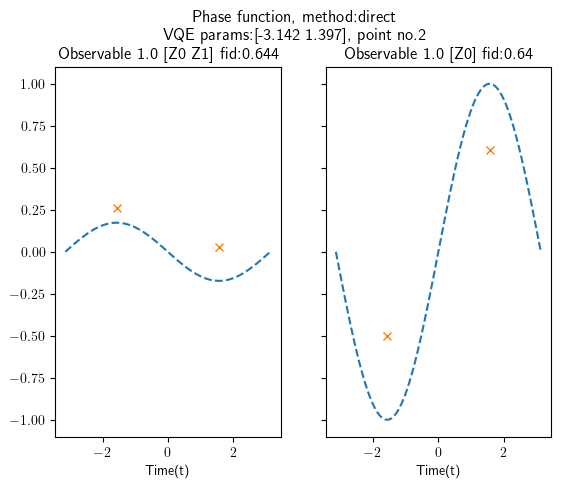

[0.0, 0.0]
{'1.0 [Z0 Z1]': 0.532, '1.0 [Z0]': 0.888}


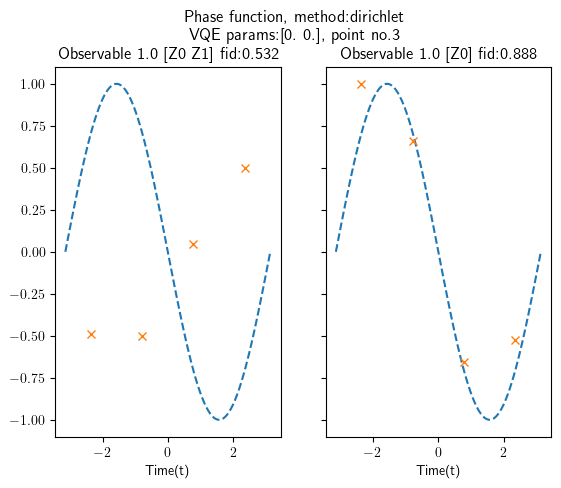

{'1.0 [Z0 Z1]': 0.655, '1.0 [Z0]': 0.887}


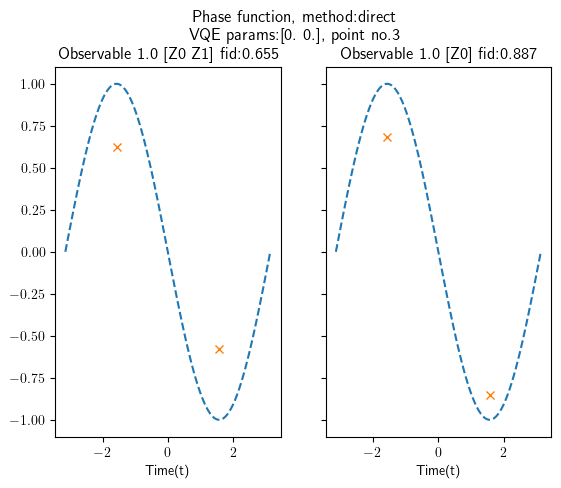

[3.1415926536, -1.3969615333]
{'1.0 [Z0 Z1]': 0.541, '1.0 [Z0]': 0.695}


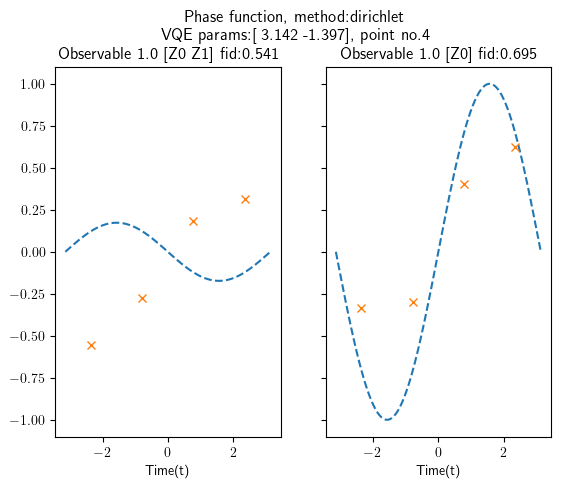

{'1.0 [Z0 Z1]': 0.513, '1.0 [Z0]': 0.65}


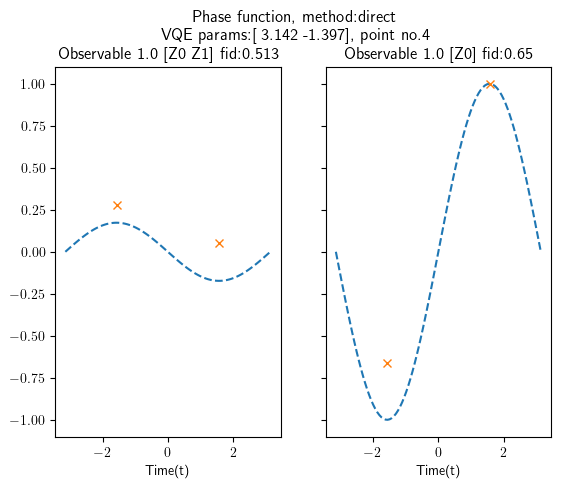

[6.2831853072, -2.7939230666]
{'1.0 [Z0 Z1]': 0.399, '1.0 [Z0]': 0.7}


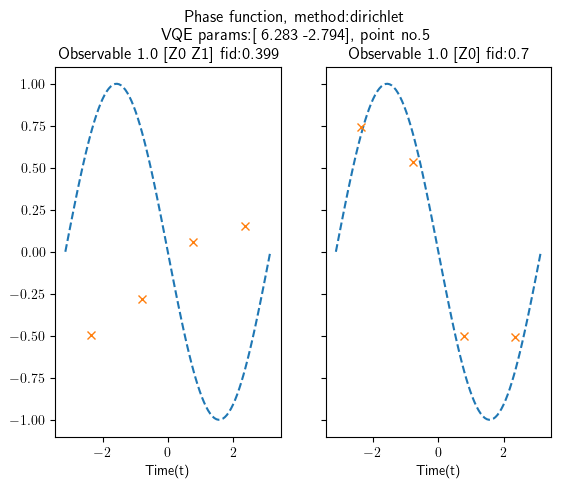

{'1.0 [Z0 Z1]': 0.392, '1.0 [Z0]': 0.702}


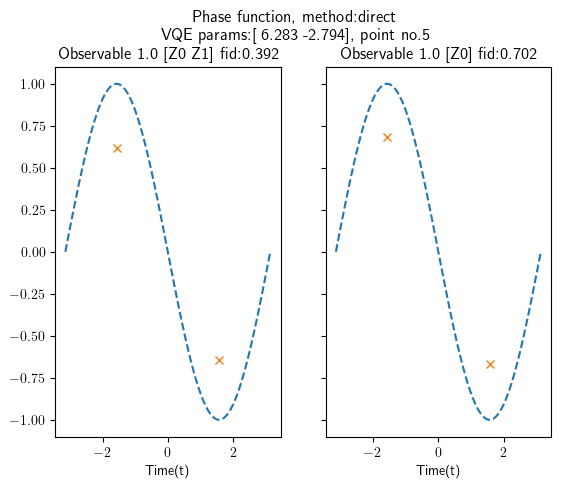

[9.4247779608, -4.1908845999]
{'1.0 [Z0 Z1]': 0.51, '1.0 [Z0]': 0.561}


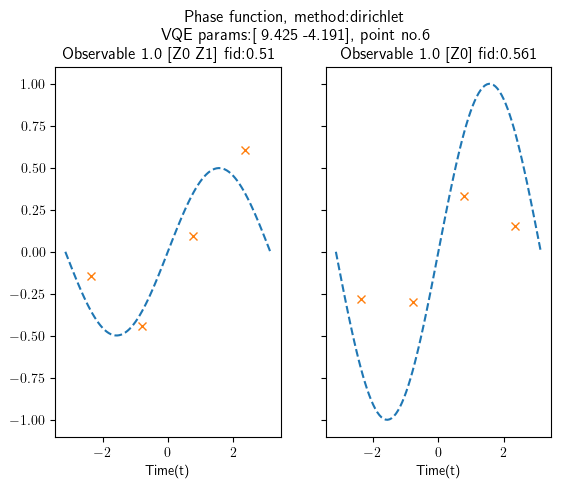

{'1.0 [Z0 Z1]': 0.612, '1.0 [Z0]': 0.633}


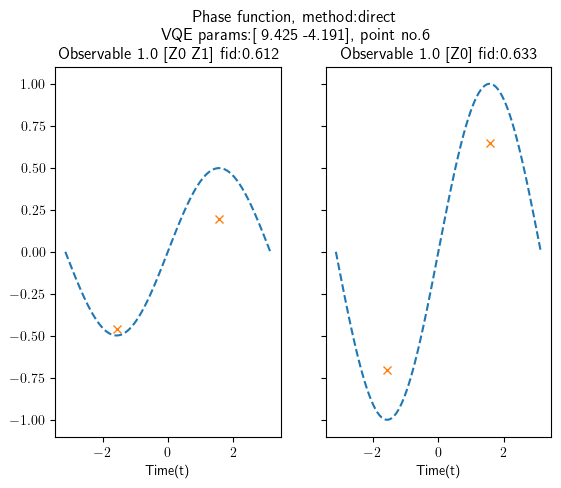

In [67]:
phase_func_imag_dev={}
phase_func_imag_analytic={}
vpe_expvals={}
vpe_expvals_times={}
fidelities={}

num_linspace_points_analytic = 100
an_times= np.linspace(-np.pi, np.pi, num=num_linspace_points_analytic)

for idx, param in enumerate(unique_params_3qb):
    print(param)
    param_mask=vpe_data_3qb['parameter'].apply(lambda x: all(val is None or val in param for val in x) if x is not None else False)
    cached_param_mask=vpe_data_3qb['cached_params'].apply(lambda x: all(val is None or val in param for val in x) if x is not None else False)
    param_filt=vpe_data_3qb[param_mask]
    #param_filt=vpe_data[vpe_data['parameter']==param]
    #cached_param_filt=vpe_data[vpe_data['cached_params']==param]
    cached_param_filt=vpe_data_3qb[cached_param_mask]
    for method in param_filt['expval_method'].dropna().unique():
        #method='dirichlet'
        method_filt=param_filt[param_filt['expval_method']==method]
        cached_method_filt=cached_param_filt[cached_param_filt['expval_method']==method]
        for obs in method_filt['observable'].dropna().unique():
            #phase_func_imag_dev[obs]=method_filt[method_filt['observable']==obs].cfvpe_phase_function_imag_arr.to_numpy()[0]
            phase_func_imag_analytic[obs]=method_filt[method_filt['observable']==obs].cfvpe_ref_phase_function_imag_arr.to_numpy()[0]
            cached_obs_filt=cached_method_filt[cached_method_filt['observable']==obs]
            mask=cached_obs_filt[cached_obs_filt['cached_value_str']=='expvalYphased_ps']
            fidelities[obs]=np.round(cached_obs_filt[cached_obs_filt['cached_value_str']=='fidelity'].cached_value.to_numpy()[0], 3)
            for time in mask.cached_time.unique():
                vpe_expvals[obs]=mask.cached_value.to_numpy()
                vpe_expvals_times[obs]=mask.cached_time.to_numpy()
        print(fidelities)
        fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
        
        ax1.plot(an_times, phase_func_imag_analytic[unique_obs_3qb[0]], linestyle='--')
        ax1.plot(vpe_expvals_times[unique_obs_3qb[0]], vpe_expvals[unique_obs_3qb[0]], 'x')
        ax1.set_title('Observable '+unique_obs_3qb[0]+ ' fid:'+str(fidelities[unique_obs_3qb[0]]))
        ax1.set_xlabel('Time(t)')
        
        ax2.plot(an_times, phase_func_imag_analytic[unique_obs_3qb[1]], linestyle='--')
        ax2.plot(vpe_expvals_times[unique_obs_3qb[1]], vpe_expvals[unique_obs_3qb[1]], 'x')
        ax2.set_title('Observable '+unique_obs_3qb[1]+' fid:'+str(fidelities[unique_obs_3qb[1]]))
        ax2.set_xlabel('Time(t)')
        
        fig.suptitle('Phase function, method:'+str(method)+'\n VQE params:'+str(np.round(param,3))+', point no.'+str(idx),y=1.)
        from pathlib import Path
        out_path=notebook_path+"/mainz_phase_fn_plots_3qubits/"+'phase_fn_'+str(method)+str(np.round(param,3))+'no_'+str(idx)+'.pdf'
        Path(out_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(out_path)
        plt.show()

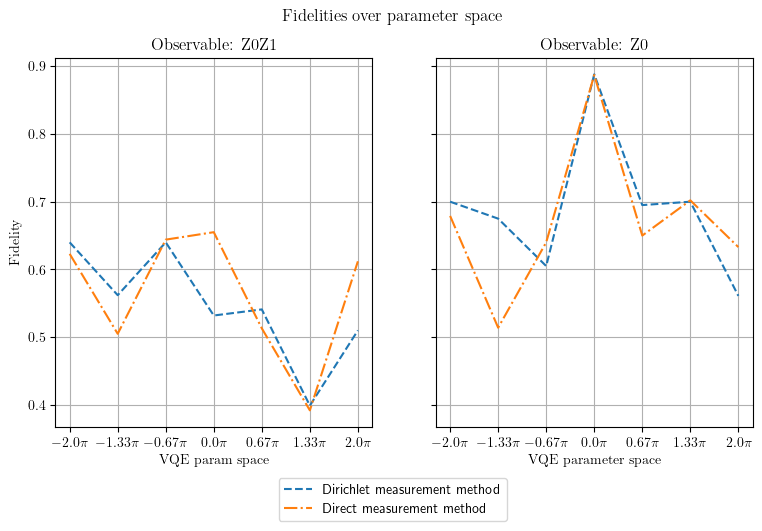

In [63]:
fids=[]

params_sweep_space = np.linspace(-2*np.pi, 2*np.pi, num=7)
params_for_fids=[param for param in params_sweep_space]

fids_for_z0_over_methods={}
fids_for_z0z1_over_methods={}
fids_for_z0_over_params_dirichlet=[]
fids_for_z0_over_params_direct=[]
fids_for_z0z1_over_params_dirichlet=[]
fids_for_z0z1_over_params_direct=[]

for idx, param in enumerate(unique_params_3qb):
    #print(param)
    param_mask=vpe_data_3qb['parameter'].apply(lambda x: all(val is None or val in param for val in x) if x is not None else False)
    cached_param_mask=vpe_data_3qb['cached_params'].apply(lambda x: all(val is None or val in param for val in x) if x is not None else False)
    #param_filt=vpe_data[vpe_data['parameter']==param]
    param_filt=vpe_data_3qb[param_mask]
    #cached_param_filt=vpe_data[vpe_data['cached_params']==param]
    cached_param_filt=vpe_data_3qb[cached_param_mask]
    for method in param_filt['expval_method'].dropna().unique():
        #method='dirichlet'
        method_filt=param_filt[param_filt['expval_method']==method]
        cached_method_filt=cached_param_filt[cached_param_filt['expval_method']==method]
        for obs in method_filt['observable'].dropna().unique():
            #phase_func_imag_dev[obs]=method_filt[method_filt['observable']==obs].cfvpe_phase_function_imag_arr.to_numpy()[0]
            phase_func_imag_analytic[obs]=method_filt[method_filt['observable']==obs].cfvpe_ref_phase_function_imag_arr.to_numpy()[0]

            cached_obs_filt=cached_method_filt[cached_method_filt['observable']==obs]
            mask=cached_obs_filt[cached_obs_filt['cached_value_str']=='expvalYphased_ps']
            fidelities[obs]=np.round(cached_obs_filt[cached_obs_filt['cached_value_str']=='fidelity'].cached_value.to_numpy()[0], 3)
            fids.append(fidelities[obs])

        #print('fidelities:',fidelities)
        fids_for_z0_over_methods[method]=fidelities[unique_obs_3qb[0]]
        fids_for_z0z1_over_methods[method]=fidelities[unique_obs_3qb[1]]
    fids_for_z0_over_params_dirichlet.append(fids_for_z0_over_methods['dirichlet'])
    fids_for_z0_over_params_direct.append(fids_for_z0_over_methods['direct'])
    fids_for_z0z1_over_params_dirichlet.append(fids_for_z0z1_over_methods['dirichlet'])
    fids_for_z0z1_over_params_direct.append(fids_for_z0z1_over_methods['direct'])


fig_dirichlet, (ax1, ax2) = plt.subplots(1,2, sharey=True)

ax1.plot(params_for_fids, fids_for_z0_over_params_dirichlet, linestyle="--", label="Dirichlet measurement method")
ax1.plot(params_for_fids, fids_for_z0_over_params_direct, linestyle="-.", label="Direct measurement method")
ax1.set_xlabel(r'$\textrm{VQE param space}$')
ax1.set_ylabel(r'$\textrm{Fidelity}$')
ax1.set_title(r'$\textrm{Observable: Z0Z1}$')
assert '1.0 [Z0 Z1]'==unique_obs_3qb[0]

pi_formatter = lambda x: r"${}\pi$".format(np.round(x / np.pi,2))
tick_labels = [pi_formatter(x) for x in params_for_fids]
ax1.set_xticks(params_for_fids, tick_labels)
ax1.grid(True)

ax2.plot(params_for_fids, fids_for_z0z1_over_params_dirichlet, linestyle="--")
ax2.plot(params_for_fids, fids_for_z0z1_over_params_direct, linestyle="-.")
ax2.set_xlabel(r'$\textrm{VQE parameter space}$')

ax2.set_title(r'$\textrm{Observable: Z0}$')
assert '1.0 [Z0]'==unique_obs_3qb[1]
ax2.set_xticks(params_for_fids, tick_labels)
ax2.grid(True)

fig_dirichlet.suptitle(r'$\textrm{Fidelities over parameter space}$')
fig_dirichlet.legend(bbox_to_anchor=(0.5, -0.1), loc='outside lower center')
fig_dirichlet.set_figwidth(9)
#fig_dirichlet.show()
from pathlib import Path
figures_filename= notebook_path+'/fidelities_3qubits/'+'/fidelities.pdf'
Path(figures_filename).parent.mkdir(parents=True, exist_ok=True)
plt.savefig(figures_filename)
plt.show()

## expvals extraction

In [31]:
import pennylane as qml
import numpy as np

def ansatz2(params, wires=range(2)):
    params=params*np.array([1.3,])
    qml.PauliX(wires=[0])
    qml.SingleExcitation(params[0], wires=[0,1])

def ansatz3(params, wires=range(3)):
    params=params*np.array([1.5,-0.667])
    qml.PauliX(wires=[0])
    qml.SingleExcitation(params[0], wires=[0,1])
    qml.SingleExcitation(params[1], wires=[1,2])

In [32]:
an_space=np.linspace(-2*np.pi, 2*np.pi, num=100)
dat_space=np.linspace(-2*np.pi, 2*np.pi, num=7)
full_space=sorted([*dat_space, *an_space])
param= [-2*np.pi]

def ansatz2(params, wires=range(2)):
    params=params*np.array([1.3,])
    qml.PauliX(wires=[0])
    qml.SingleExcitation(params[0], wires=[0,1])

dev=qml.device('default.qubit', shots=None, wires=2)
@qml.qnode(dev)
def circ(params):
    ansatz2(params, wires=range(2))
    #return qml.expval(qml.PauliZ(0))       
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))
# exp =circ(an_space[78])
# exp

In [33]:
an_space=np.linspace(-2*np.pi, 2*np.pi, num=100)
dat_space=np.linspace(-2*np.pi, 2*np.pi, num=7)
full_space=sorted([*dat_space, *an_space])

dev2=qml.device('default.qubit', shots=None, wires=3)
@qml.qnode(dev2)
def circ2(params, obs):
    ansatz3(params, wires=range(3))
    if obs=='1.0 [Z0]':
        return qml.expval(qml.PauliZ(0))       
    elif obs=='1.0 [Z0 Z1]':
        return qml.expval(qml.PauliZ(0)@qml.PauliZ(1))
    else:
        raise ValueError('Wrong observable')
#param_sweep_space=np.linspace(-2*np.pi, 2*np.pi)
#params_sweep_space_analytic = np.linspace(-2*np.pi, 2*np.pi, num=num_linspace_points_analytic)
#params_sweep_space_analytic = sorted([*params_sweep_space, *params_sweep_space_analytic])
#analytic_results_exp= [circ2(x) for x in an_space]

#plt.plot(an_space,analytic_results_exp, linestyle="--")


## 2X3 FIGURES Expectation Value Figures (3 qubit circuit)

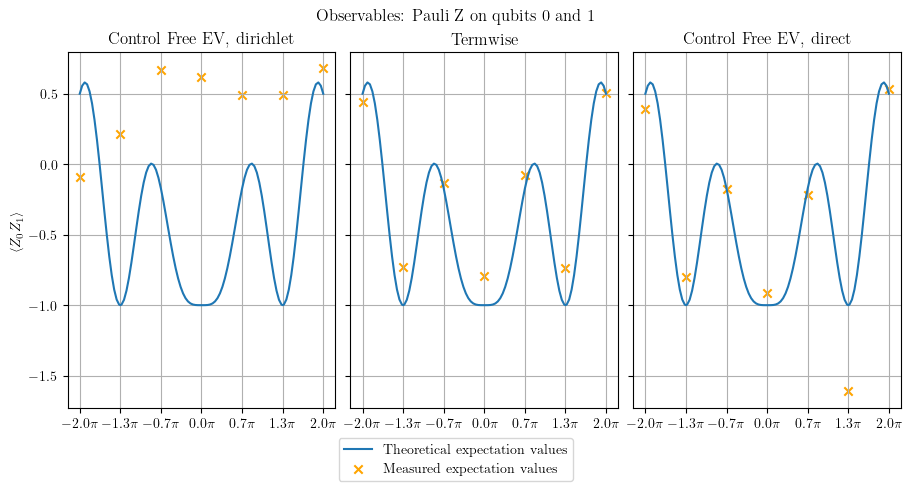

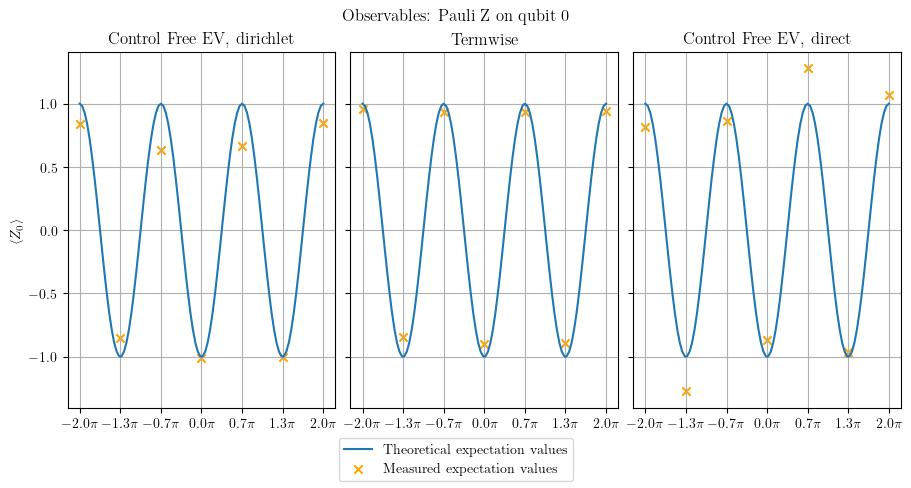

In [36]:
from pathlib import Path

#for expval_meth in vpe_data.expval_method.dropna().unique():
for obs in vpe_data_3qb.observable.dropna().unique():
    dirichlet_data=vpe_data_3qb[(vpe_data_3qb['expval_method']==vpe_data_3qb.expval_method.dropna().unique()[0]) & (vpe_data_3qb['observable']==obs)]
    direct_data=vpe_data_3qb[(vpe_data_3qb['expval_method']==vpe_data_3qb.expval_method.dropna().unique()[1]) & (vpe_data_3qb['observable']==obs)]
    dirichlet_vpe_expvals=dirichlet_data['cfvpe_expvals'].dropna()
    direct_vpe_expvals=direct_data['cfvpe_expvals'].dropna()
    termwise_expvals=direct_data['termwise_expvals'].dropna() #termwise expectation values are the same for both data sets
    #expvals_list[str(expval_meth+'_'+obs)]=expvals
    params=direct_data['parameter'].dropna() #the evaluation of the expectation 
    #pars[str(expval_meth+'_'+obs)]=params
    param_sweep_space = np.linspace(-2*np.pi, 2*np.pi, num=len(params))
    an_param_sweep_space = np.linspace(-2*np.pi, 2*np.pi, num=100)
    an_param_sweep_space = sorted([*param_sweep_space, *an_param_sweep_space])
    an_expvals=[circ2(x, obs) for x in an_param_sweep_space]

    fig1, ((ax1,ax2,ax3)) = plt.subplots(1,3,  layout='constrained',sharey=True, sharex=True)
    ax1.plot(an_param_sweep_space,an_expvals, linestyle='-',label=r'$\textrm{Theoretical expectation values}$')
    ax1.scatter(param_sweep_space, dirichlet_vpe_expvals, color='orange', marker='x', label=r'$\textrm{Measured expectation values}$')
    ax1.set_title(r'$\textrm{Control Free EV, ' + str(vpe_data_3qb.expval_method.dropna().unique()[0]) + '}$')

    ax2.plot(an_param_sweep_space,an_expvals, linestyle='-', )#label='Theoretical expectation values')
    ax2.scatter(param_sweep_space, termwise_expvals, color='orange', marker='x',)# label='Measured expectation values')
    ax2.set_title(r'$\textrm{Termwise}$')

    ax3.plot(an_param_sweep_space,an_expvals, linestyle='-')
    ax3.scatter(param_sweep_space, direct_vpe_expvals, color='orange', marker='x')
    ax3.set_title(r'$\textrm{Control Free EV, ' + str(vpe_data_3qb.expval_method.dropna().unique()[1]) +'}$')

    # ax4.plot(an_param_sweep_space,an_expvals, linestyle='-', )#label='Theoretical expectation values')
    # ax4.scatter(param_sweep_space, termwise_expvals, color='orange', marker='x',)# label='Measured expectation values')
    # ax4.set_title('Termwise')

        
    ax1.grid(True)
    ax2.grid(True)
    ax3.grid(True)
    
    #ax4.grid(True)
    #ax2.legend()
    
    fig1.legend(loc='outside lower center')
    if obs=='1.0 [Z0]':
        fig1.suptitle(r'$\textrm{Observables: Pauli Z on qubit 0}$')
        ax1.set_ylabel(r'$\langle Z_0 \rangle $')
        #ax3.set_ylabel(r'$\langle Z_0 \rangle $')
    else:
        fig1.suptitle(r'$\textrm{Observables: Pauli Z on qubits 0 and 1}$')
        ax1.set_ylabel(r'$\langle Z_0 Z_1 \rangle $')
        #ax3.set_ylabel(r'$\langle Z_0 Z_1 \rangle $')
    #custom ticks
    pi_formatter = lambda x: r"${}\pi$".format(np.round(x / np.pi,1))
    tick_labels = [pi_formatter(x) for x in param_sweep_space]
    ax1.set_xticks(param_sweep_space, tick_labels)
    ax2.set_xticks(param_sweep_space, tick_labels)
    ax3.set_xticks(param_sweep_space, tick_labels)
    #ax4.set_xticks(param_sweep_space, tick_labels)
    
    figures_filename= notebook_path+'/experiment_expvals_2x3_3qubits/'+'/obs_'+str(obs)+'.pdf'
    Path(figures_filename).parent.mkdir(parents=True, exist_ok=True)
    fig1.set_figwidth(9)
    plt.savefig(figures_filename)
    plt.show()
    #plt.clf()

    


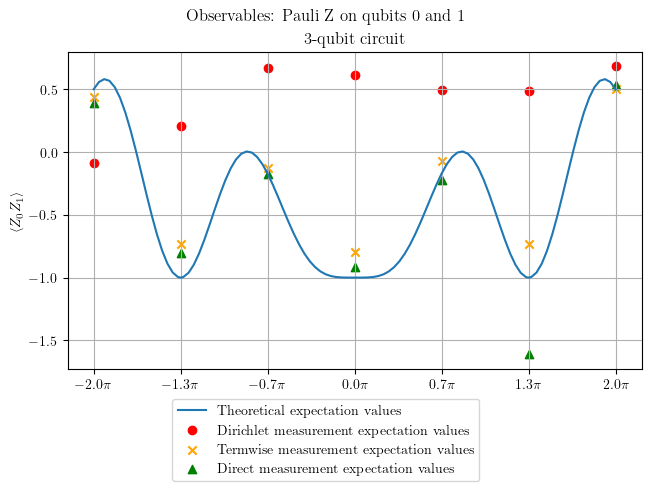

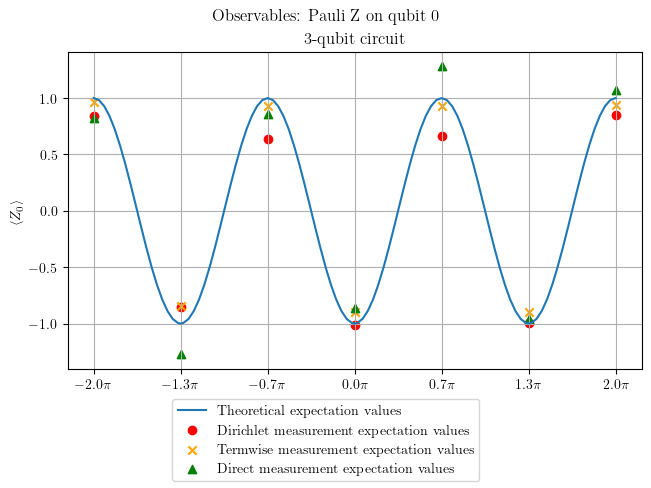

In [87]:
from pathlib import Path

#for expval_meth in vpe_data.expval_method.dropna().unique():
for obs in vpe_data_3qb.observable.dropna().unique():
    dirichlet_data_3qb=vpe_data_3qb[(vpe_data_3qb['expval_method']==vpe_data_3qb.expval_method.dropna().unique()[0]) & (vpe_data_3qb['observable']==obs)]
    direct_data_3qb=vpe_data_3qb[(vpe_data_3qb['expval_method']==vpe_data_3qb.expval_method.dropna().unique()[1]) & (vpe_data_3qb['observable']==obs)]
    dirichlet_vpe_expvals_3qb=dirichlet_data_3qb['cfvpe_expvals'].dropna()
    direct_vpe_expvals_3qb=direct_data_3qb['cfvpe_expvals'].dropna()
    termwise_expvals_3qb=direct_data_3qb['termwise_expvals'].dropna() #termwise expectation values are the same for both data sets
    #expvals_list[str(expval_meth+'_'+obs)]=expvals
    params_3qb=direct_data_3qb['parameter'].dropna() #the evaluation of the expectation 
    #pars[str(expval_meth+'_'+obs)]=params
    param_sweep_space_3qb = np.linspace(-2*np.pi, 2*np.pi, num=len(params_3qb))
    an_param_sweep_space_3qb = np.linspace(-2*np.pi, 2*np.pi, num=100)
    an_param_sweep_space_3qb = sorted([*param_sweep_space_3qb, *an_param_sweep_space_3qb])
    an_expvals_3qb=[circ2(x, obs) for x in an_param_sweep_space_3qb]

    fig1, ((ax1)) = plt.subplots(1,1,  layout='constrained',sharey=True, sharex=True)
    ax1.plot(an_param_sweep_space_3qb,an_expvals_3qb, linestyle='-',label=r'$\textrm{Theoretical expectation values}$')
    ax1.scatter(param_sweep_space_3qb, dirichlet_vpe_expvals_3qb, color='red', marker='o', label=r'$\textrm{Dirichlet measurement expectation values}$')
    ax1.set_title(r'$\textrm{3-qubit circuit}$')
    ax1.scatter(param_sweep_space_3qb, termwise_expvals_3qb, color='orange', marker='x', label=r'$\textrm{Termwise measurement expectation values}$')# label='Measured expectation values')
    ax1.scatter(param_sweep_space_3qb, direct_vpe_expvals_3qb, color='green', marker='^', label=r'$\textrm{Direct measurement expectation values}$')

    ax1.grid(True)
    fig1.legend(loc='outside lower center')
    if obs=='1.0 [Z0]':
        fig1.suptitle(r'$\textrm{Observables: Pauli Z on qubit 0}$')
        ax1.set_ylabel(r'$\langle Z_0 \rangle $')
        #ax3.set_ylabel(r'$\langle Z_0 \rangle $')
    else:
        fig1.suptitle(r'$\textrm{Observables: Pauli Z on qubits 0 and 1}$')
        ax1.set_ylabel(r'$\langle Z_0 Z_1 \rangle $')
        #ax3.set_ylabel(r'$\langle Z_0 Z_1 \rangle $')
    #custom ticks
    pi_formatter = lambda x: r"${}\pi$".format(np.round(x / np.pi,1))
    tick_labels_3qb = [pi_formatter(x) for x in param_sweep_space_3qb]
    ax1.set_xticks(param_sweep_space_3qb, tick_labels_3qb)
    
    figures_filename= notebook_path+'/experiment_expvals_2x1_3qubits/'+'/obs_'+str(obs)+'.pdf'
    Path(figures_filename).parent.mkdir(parents=True, exist_ok=True)
    #fig1.set_figwidth(9)
    plt.savefig(figures_filename)
    plt.show()
    #plt.clf()

    


## Expectation value Figures (2 qubit circuit)

In [74]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
#import covvqetools as cov

plt.rcParams.update({
  "text.usetex": True,
  #"font.family": "Helvetica"
})

notebook_path = os.path.dirname(os.path.realpath("__file__"))

vpe_data_path_2qb = notebook_path+'/mainz_phase_fn_data/redtrap_many_shots_v25_size2_opt_on/system_size_2'

vpe_data_2qb = pd.read_json(vpe_data_path_2qb+'/all_data.json')

In [75]:
unique_params_2qb=[]
unique_obs_2qb=vpe_data_2qb.observable.dropna().unique()
for item in vpe_data_2qb.parameter.dropna().items():
    if item[1] not in unique_params_2qb:
        unique_params_2qb.append(item[1])

print("Unique parameters: \n", unique_params_2qb)
print("Unique observables: \n", unique_obs_2qb)

Unique parameters: 
 [[-8.1681408993], [-6.5345127195], [-4.9008845396], [-3.2672563597], [-1.6336281799], [0.0], [1.6336281799], [3.2672563597], [4.9008845396], [6.5345127195], [8.1681408993]]
Unique observables: 
 ['1.0 [Z0 Z1]' '1.0 [Z0]']


In [76]:
an_space=np.linspace(-2*np.pi, 2*np.pi, num=100)
dat_space=np.linspace(-2*np.pi, 2*np.pi, num=len(unique_params_2qb))
full_space=sorted([*dat_space, *an_space])
param= [-2*np.pi]

def ansatz2(params, wires=range(2)):
    params=params*np.array([1.3,])
    qml.PauliX(wires=[0])
    qml.SingleExcitation(params[0], wires=[0,1])

dev=qml.device('default.qubit', shots=None, wires=2)
@qml.qnode(dev)
def circ(params, obs):
    ansatz2(params, wires=range(2))
    #return qml.expval(qml.PauliZ(0))
    if obs=='1.0 [Z0]':
        return qml.expval(qml.PauliZ(0))       
    elif obs=='1.0 [Z0 Z1]':
        return qml.expval(qml.PauliZ(0)@qml.PauliZ(1))
    else:
        raise ValueError('Wrong observable')

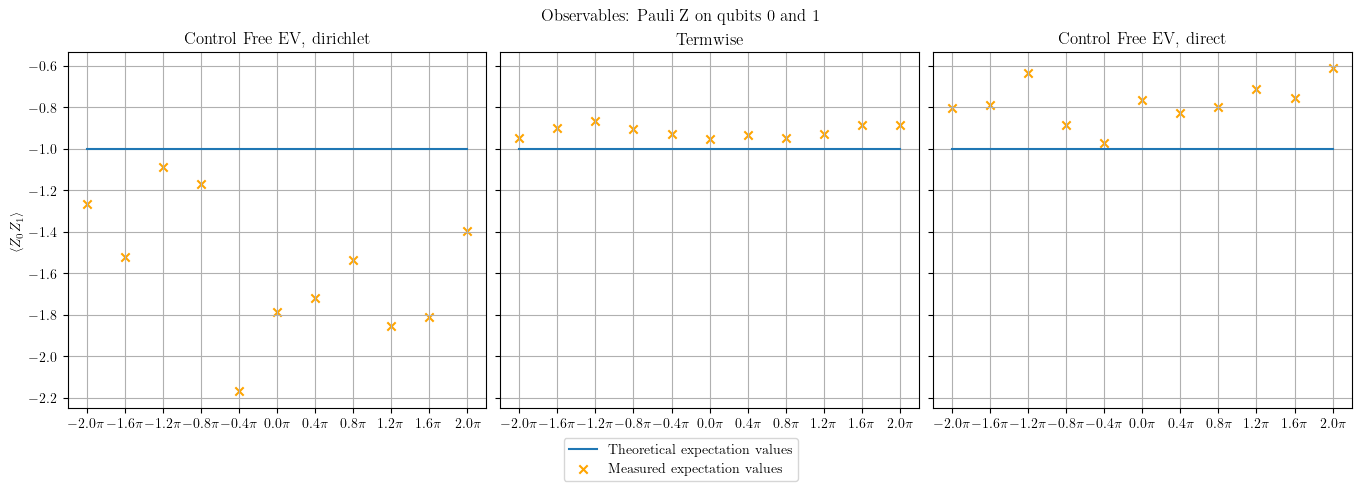

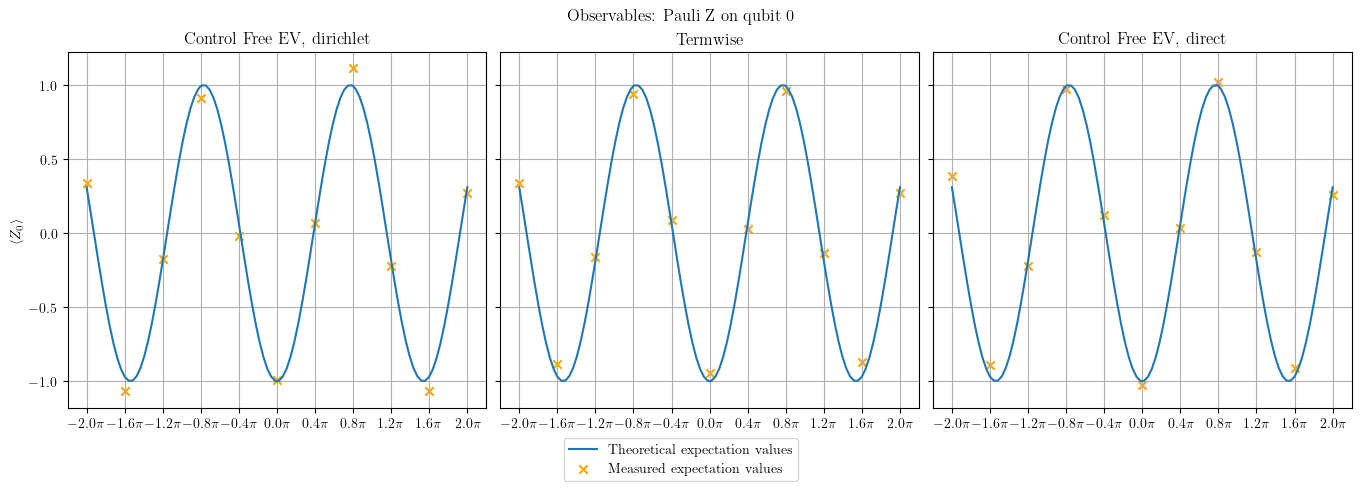

In [77]:
from pathlib import Path

#for expval_meth in vpe_data.expval_method.dropna().unique():
for obs in vpe_data_2qb.observable.dropna().unique():
    dirichlet_data=vpe_data_2qb[(vpe_data_2qb['expval_method']==vpe_data_2qb.expval_method.dropna().unique()[0]) & (vpe_data_2qb['observable']==obs)]
    direct_data=vpe_data_2qb[(vpe_data_2qb['expval_method']==vpe_data_2qb.expval_method.dropna().unique()[1]) & (vpe_data_2qb['observable']==obs)]
    dirichlet_vpe_expvals=dirichlet_data['cfvpe_expvals'].dropna()
    direct_vpe_expvals=direct_data['cfvpe_expvals'].dropna()
    termwise_expvals=direct_data['termwise_expvals'].dropna() #termwise expectation values are the same for both data sets
    #expvals_list[str(expval_meth+'_'+obs)]=expvals
    params=direct_data['parameter'].dropna() #the evaluation of the expectation 
    #pars[str(expval_meth+'_'+obs)]=params
    param_sweep_space = np.linspace(-2*np.pi, 2*np.pi, num=len(params))
    an_param_sweep_space = np.linspace(-2*np.pi, 2*np.pi, num=100)
    an_param_sweep_space = sorted([*param_sweep_space, *an_param_sweep_space])
    an_expvals=[circ(x, obs) for x in an_param_sweep_space]

    fig1, ((ax1,ax2,ax3)) = plt.subplots(1,3,  layout='constrained',sharey=True, sharex=True)
    ax1.plot(an_param_sweep_space,an_expvals, linestyle='-',label=r'$\textrm{Theoretical expectation values}$')
    ax1.scatter(param_sweep_space, dirichlet_vpe_expvals, color='orange', marker='x', label=r'$\textrm{Measured expectation values}$')
    ax1.set_title(r'$\textrm{Control Free EV, ' + str(vpe_data_2qb.expval_method.dropna().unique()[0]) + '}$')

    ax2.plot(an_param_sweep_space,an_expvals, linestyle='-', )#label='Theoretical expectation values')
    ax2.scatter(param_sweep_space, termwise_expvals, color='orange', marker='x',)# label='Measured expectation values')
    ax2.set_title(r'$\textrm{Termwise}$')

    ax3.plot(an_param_sweep_space,an_expvals, linestyle='-')
    ax3.scatter(param_sweep_space, direct_vpe_expvals, color='orange', marker='x')
    ax3.set_title(r'$\textrm{Control Free EV, ' + str(vpe_data_2qb.expval_method.dropna().unique()[1]) +'}$')

    # ax4.plot(an_param_sweep_space,an_expvals, linestyle='-', )#label='Theoretical expectation values')
    # ax4.scatter(param_sweep_space, termwise_expvals, color='orange', marker='x',)# label='Measured expectation values')
    # ax4.set_title('Termwise')

        
    ax1.grid(True)
    ax2.grid(True)
    ax3.grid(True)
    #ax4.grid(True)
    #ax2.legend()
    
    fig1.legend(loc='outside lower center')
    if obs=='1.0 [Z0]':
        fig1.suptitle(r'$\textrm{Observables: Pauli Z on qubit 0}$')
        ax1.set_ylabel(r'$\langle Z_0 \rangle $')
        #ax3.set_ylabel(r'$\langle Z_0 \rangle $')
    else:
        fig1.suptitle(r'$\textrm{Observables: Pauli Z on qubits 0 and 1}$')
        ax1.set_ylabel(r'$\langle Z_0 Z_1 \rangle $')
        #ax3.set_ylabel(r'$\langle Z_0 Z_1 \rangle $')
    #custom ticks
    pi_formatter = lambda x: r"${}\pi$".format(np.round(x / np.pi,1))
    tick_labels = [pi_formatter(x) for x in param_sweep_space]
    ax1.set_xticks(param_sweep_space, tick_labels)
    ax2.set_xticks(param_sweep_space, tick_labels)
    ax3.set_xticks(param_sweep_space, tick_labels)
    #ax4.set_xticks(param_sweep_space, tick_labels)
    
    figures_filename= notebook_path+'/experiment_expvals_2x3_2qubits/'+'/obs_'+str(obs)+'.pdf'
    Path(figures_filename).parent.mkdir(parents=True, exist_ok=True)
    fig1.set_figwidth(13.5)
    plt.savefig(figures_filename)
    plt.show()
    #plt.clf()

    


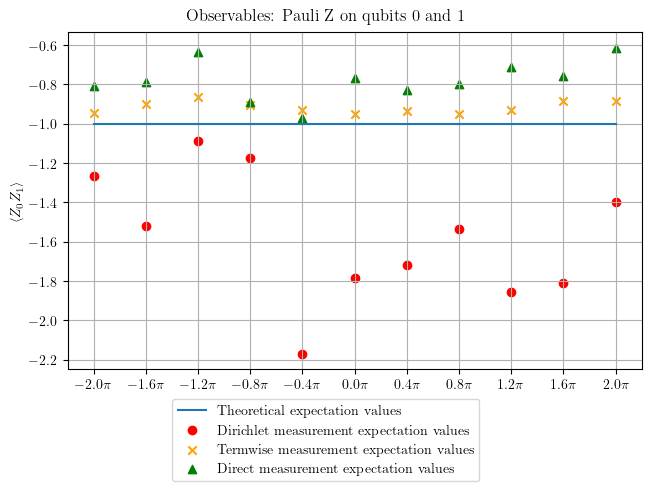

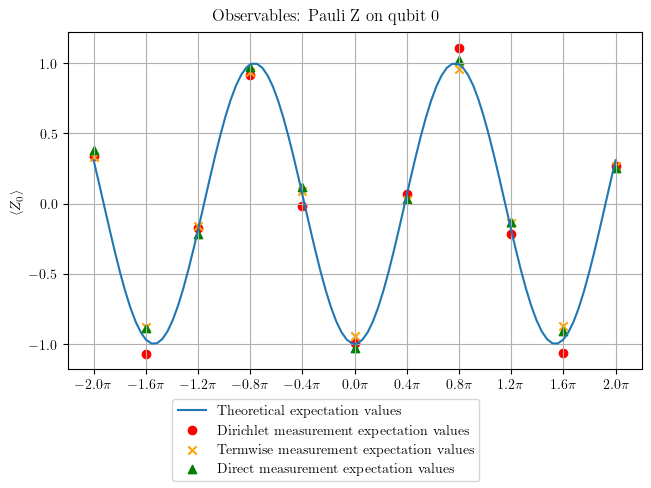

In [81]:
from pathlib import Path

#for expval_meth in vpe_data.expval_method.dropna().unique():
for obs in vpe_data_2qb.observable.dropna().unique():
    dirichlet_data=vpe_data_2qb[(vpe_data_2qb['expval_method']==vpe_data_2qb.expval_method.dropna().unique()[0]) & (vpe_data_2qb['observable']==obs)]
    direct_data=vpe_data_2qb[(vpe_data_2qb['expval_method']==vpe_data_2qb.expval_method.dropna().unique()[1]) & (vpe_data_2qb['observable']==obs)]
    dirichlet_vpe_expvals=dirichlet_data['cfvpe_expvals'].dropna()
    direct_vpe_expvals=direct_data['cfvpe_expvals'].dropna()
    termwise_expvals=direct_data['termwise_expvals'].dropna() #termwise expectation values are the same for both data sets
    #expvals_list[str(expval_meth+'_'+obs)]=expvals
    params=direct_data['parameter'].dropna() #the evaluation of the expectation 
    #pars[str(expval_meth+'_'+obs)]=params
    param_sweep_space = np.linspace(-2*np.pi, 2*np.pi, num=len(params))
    an_param_sweep_space = np.linspace(-2*np.pi, 2*np.pi, num=100)
    an_param_sweep_space = sorted([*param_sweep_space, *an_param_sweep_space])
    an_expvals=[circ(x, obs) for x in an_param_sweep_space]

    fig1, ((ax1)) = plt.subplots(1,1,  layout='constrained',sharey=True, sharex=True)
    ax1.plot(an_param_sweep_space,an_expvals, linestyle='-',label=r'$\textrm{Theoretical expectation values}$')
    ax1.scatter(param_sweep_space, dirichlet_vpe_expvals, color='red', marker='o', label=r'$\textrm{Dirichlet measurement expectation values}$')
    #ax1.set_title(r'$\textrm{Control Free EV, ' + str(vpe_data_3qb.expval_method.dropna().unique()[0]) + '}$')

    #ax2.plot(an_param_sweep_space,an_expvals, linestyle='-', )#label='Theoretical expectation values')
    ax1.scatter(param_sweep_space, termwise_expvals, color='orange', marker='x', label=r'$\textrm{Termwise measurement expectation values}$')# label='Measured expectation values')
    #ax2.set_title(r'$\textrm{Termwise}$')

    #ax3.plot(an_param_sweep_space,an_expvals, linestyle='-')
    ax1.scatter(param_sweep_space, direct_vpe_expvals, color='green', marker='^', label=r'$\textrm{Direct measurement expectation values}$')
    #ax3.set_title(r'$\textrm{Control Free EV, ' + str(vpe_data_3qb.expval_method.dropna().unique()[1]) +'}$')

    
        
    ax1.grid(True)
    # ax2.grid(True)
    # ax3.grid(True)
    #ax4.grid(True)
    #ax2.legend()
    
    fig1.legend(loc='outside lower center')
    if obs=='1.0 [Z0]':
        fig1.suptitle(r'$\textrm{Observables: Pauli Z on qubit 0}$')
        ax1.set_ylabel(r'$\langle Z_0 \rangle $')
        #ax3.set_ylabel(r'$\langle Z_0 \rangle $')
    else:
        fig1.suptitle(r'$\textrm{Observables: Pauli Z on qubits 0 and 1}$')
        ax1.set_ylabel(r'$\langle Z_0 Z_1 \rangle $')
        #ax3.set_ylabel(r'$\langle Z_0 Z_1 \rangle $')
    #custom ticks
    pi_formatter = lambda x: r"${}\pi$".format(np.round(x / np.pi,1))
    tick_labels = [pi_formatter(x) for x in param_sweep_space]
    ax1.set_xticks(param_sweep_space, tick_labels)
    # ax2.set_xticks(param_sweep_space, tick_labels)
    # ax3.set_xticks(param_sweep_space, tick_labels)
    #ax4.set_xticks(param_sweep_space, tick_labels)
    
    figures_filename= notebook_path+'/experiment_expvals_2x1_2qubits/'+'/obs_'+str(obs)+'.pdf'
    Path(figures_filename).parent.mkdir(parents=True, exist_ok=True)
    #fig1.set_figwidth(9)
    plt.savefig(figures_filename)
    plt.show()
    #plt.clf()

    


In [82]:
unique_params=[]
unique_obs=vpe_data_2qb.observable.dropna().unique()
for item in vpe_data_2qb.parameter.dropna().items():
    if item[1] not in unique_params:
        unique_params.append(item[1])

print("Unique parameters: \n", unique_params)
print("Unique observables: \n", unique_obs)

Unique parameters: 
 [[-8.1681408993], [-6.5345127195], [-4.9008845396], [-3.2672563597], [-1.6336281799], [0.0], [1.6336281799], [3.2672563597], [4.9008845396], [6.5345127195], [8.1681408993]]
Unique observables: 
 ['1.0 [Z0 Z1]' '1.0 [Z0]']


[-8.1681408993]
{'1.0 [Z0 Z1]': 0.773, '1.0 [Z0]': 0.883}


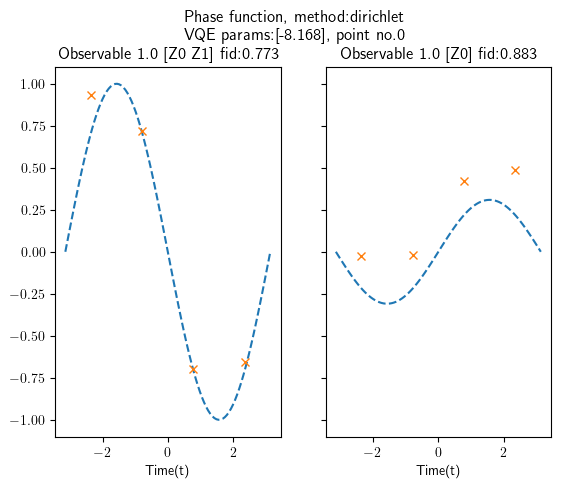

{'1.0 [Z0 Z1]': 0.536, '1.0 [Z0]': 0.807}


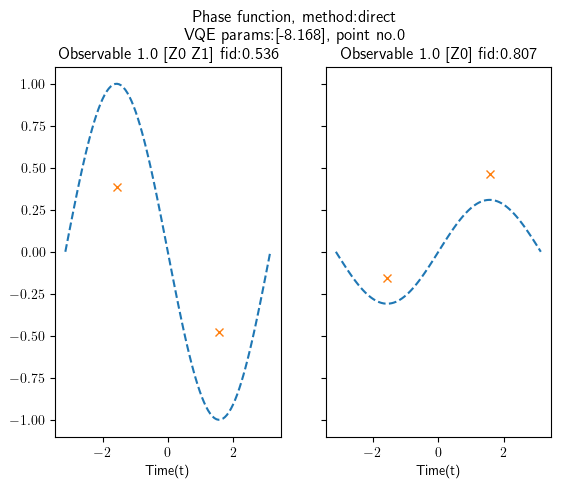

[-6.5345127195]
{'1.0 [Z0 Z1]': 0.633, '1.0 [Z0]': 0.841}


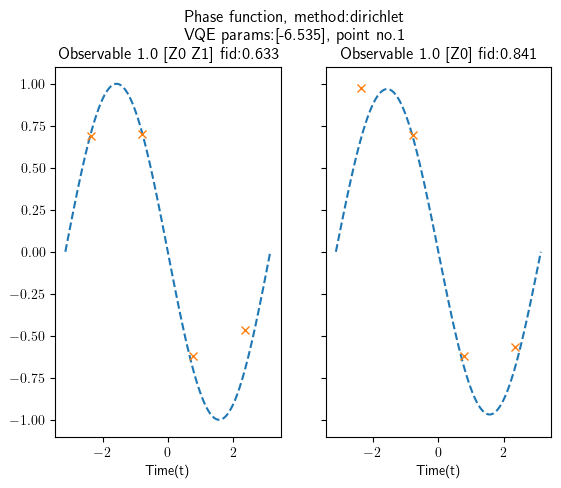

{'1.0 [Z0 Z1]': 0.439, '1.0 [Z0]': 0.784}


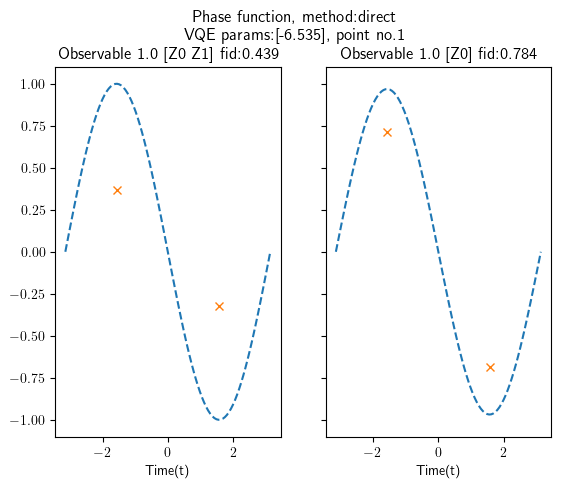

[-4.9008845396]
{'1.0 [Z0 Z1]': 0.748, '1.0 [Z0]': 0.866}


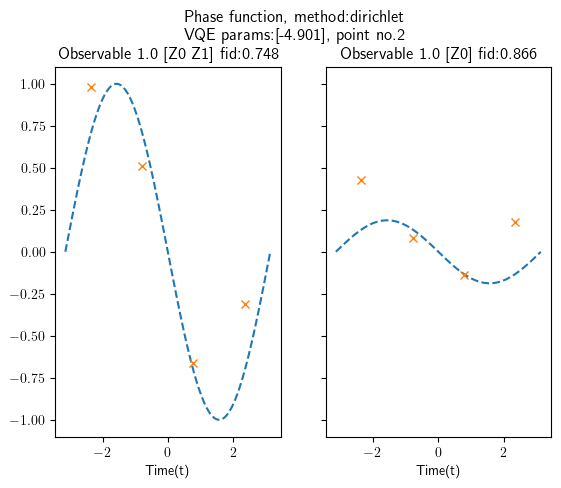

{'1.0 [Z0 Z1]': 0.466, '1.0 [Z0]': 0.776}


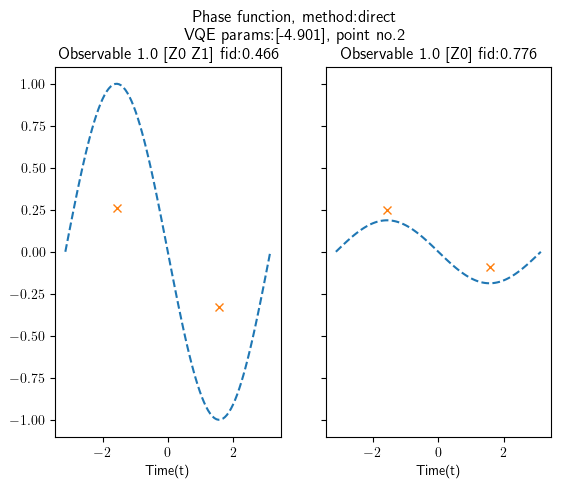

[-3.2672563597]
{'1.0 [Z0 Z1]': 0.761, '1.0 [Z0]': 0.87}


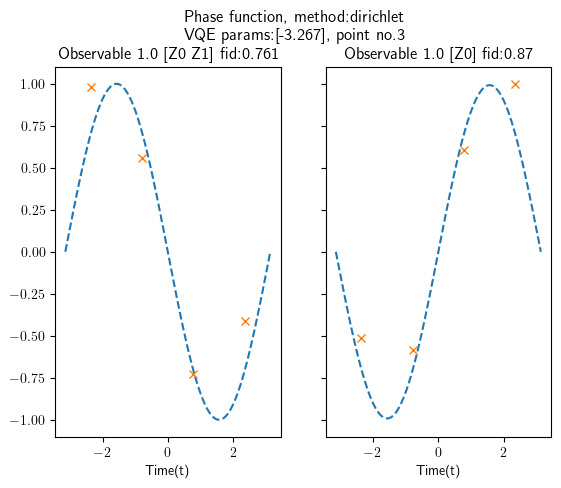

{'1.0 [Z0 Z1]': 0.498, '1.0 [Z0]': 0.809}


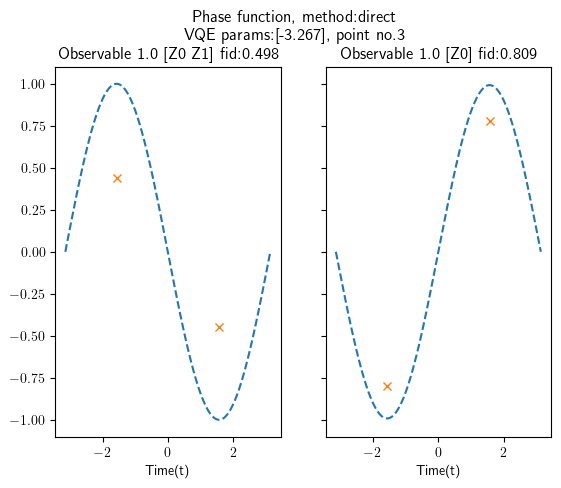

[-1.6336281799]
{'1.0 [Z0 Z1]': 0.442, '1.0 [Z0]': 0.81}


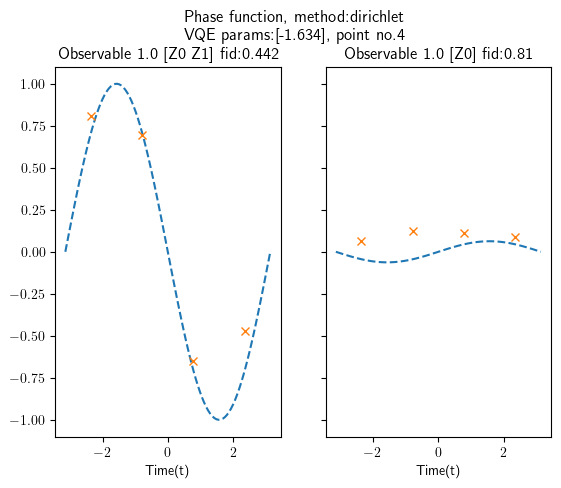

{'1.0 [Z0 Z1]': 0.48, '1.0 [Z0]': 0.752}


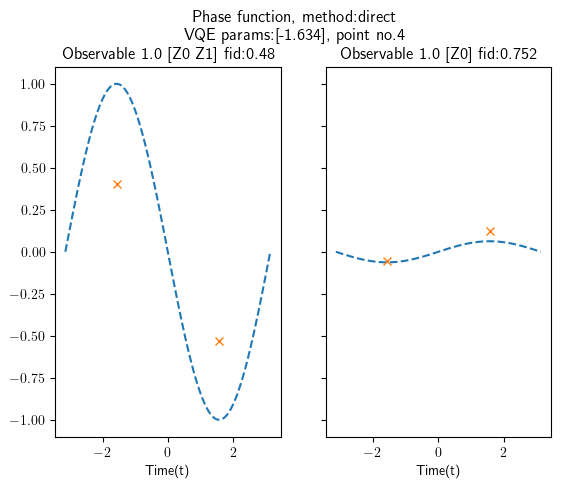

[0.0]
{'1.0 [Z0 Z1]': 0.547, '1.0 [Z0]': 0.856}


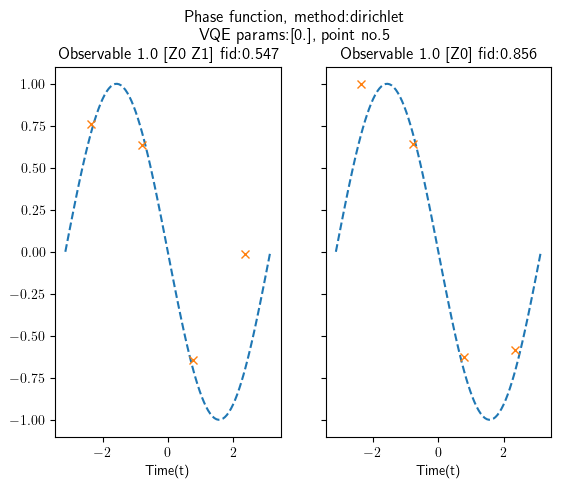

{'1.0 [Z0 Z1]': 0.672, '1.0 [Z0]': 0.872}


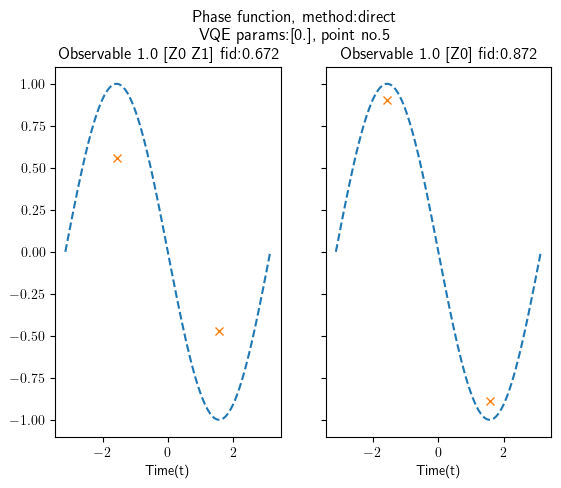

[1.6336281799]
{'1.0 [Z0 Z1]': 0.586, '1.0 [Z0]': 0.848}


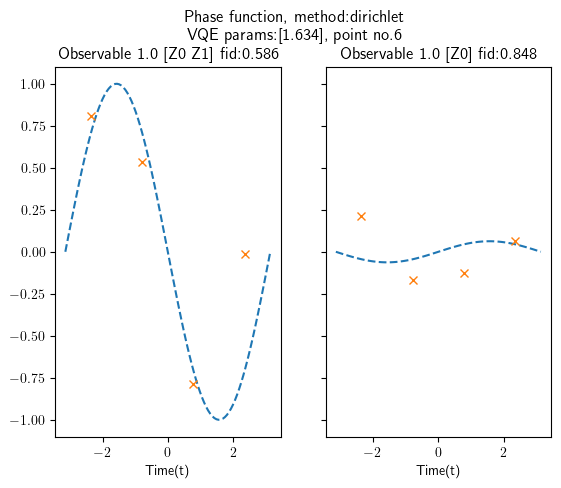

{'1.0 [Z0 Z1]': 0.503, '1.0 [Z0]': 0.772}


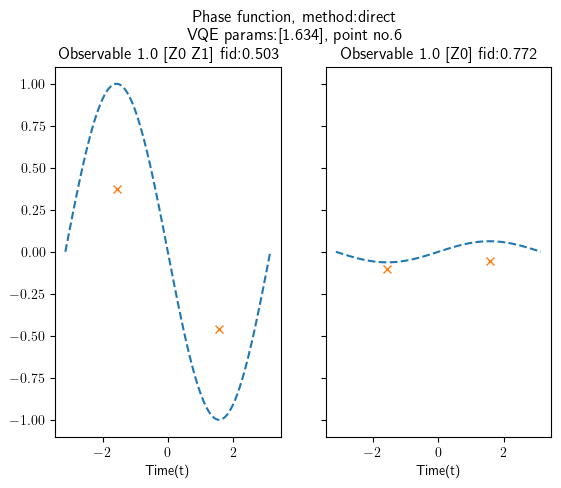

[3.2672563597]
{'1.0 [Z0 Z1]': 0.668, '1.0 [Z0]': 0.859}


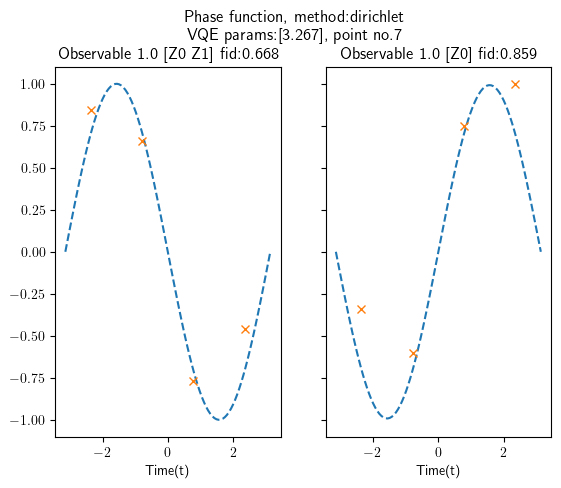

{'1.0 [Z0 Z1]': 0.604, '1.0 [Z0]': 0.789}


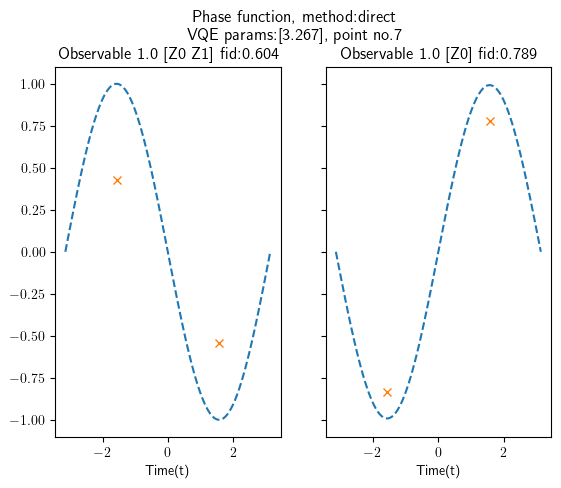

[4.9008845396]
{'1.0 [Z0 Z1]': 0.562, '1.0 [Z0]': 0.821}


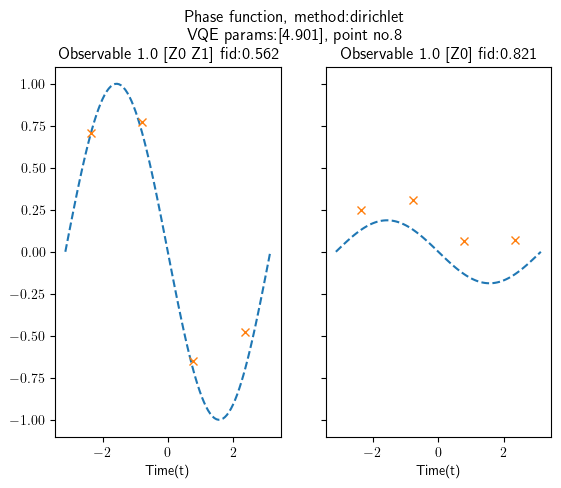

{'1.0 [Z0 Z1]': 0.584, '1.0 [Z0]': 0.746}


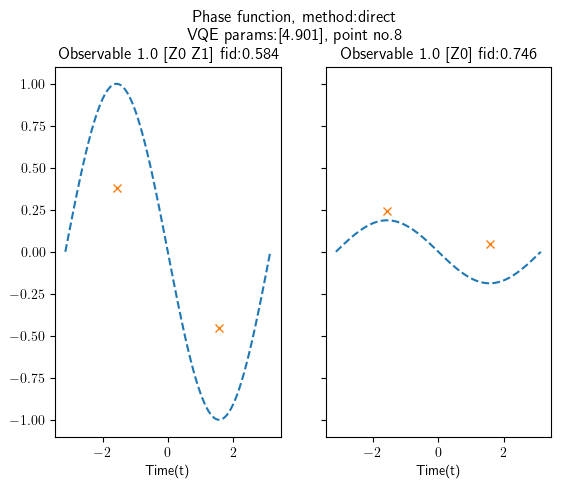

[6.5345127195]
{'1.0 [Z0 Z1]': 0.524, '1.0 [Z0]': 0.808}


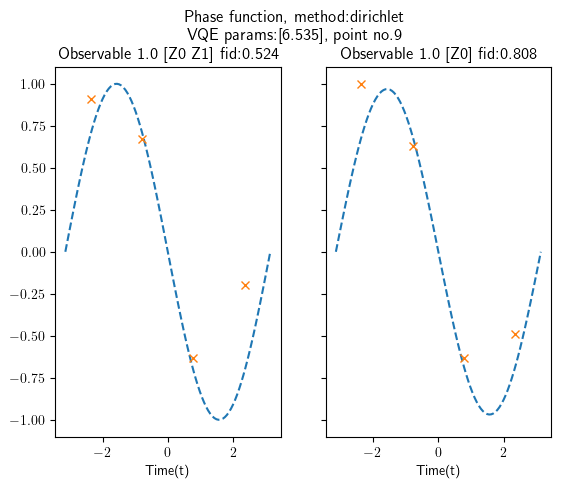

{'1.0 [Z0 Z1]': 0.442, '1.0 [Z0]': 0.787}


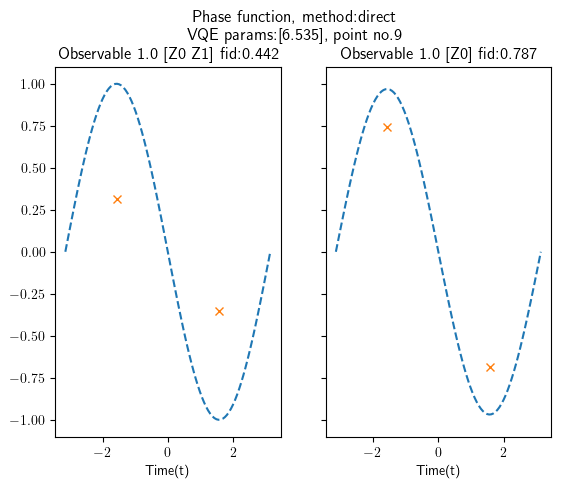

[8.1681408993]
{'1.0 [Z0 Z1]': 0.618, '1.0 [Z0]': 0.839}


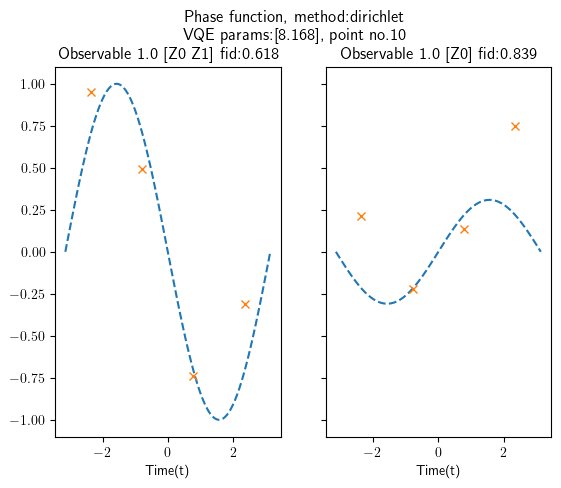

{'1.0 [Z0 Z1]': 0.552, '1.0 [Z0]': 0.816}


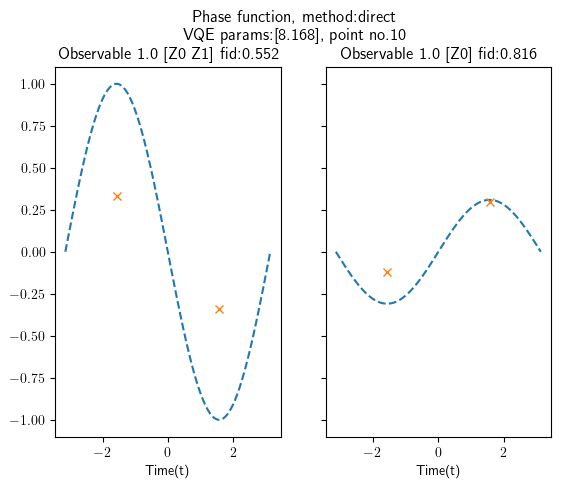

In [83]:
phase_func_imag_dev={}
phase_func_imag_analytic={}
vpe_expvals={}
vpe_expvals_times={}
fidelities={}

num_linspace_points_analytic = 100
an_times= np.linspace(-np.pi, np.pi, num=num_linspace_points_analytic)

for idx, param in enumerate(unique_params_2qb):
    print(param)
    param_mask=vpe_data_2qb['parameter'].apply(lambda x: all(val is None or val in param for val in x) if x is not None else False)
    cached_param_mask=vpe_data_2qb['cached_params'].apply(lambda x: all(val is None or val in param for val in x) if x is not None else False)
    param_filt=vpe_data_2qb[param_mask]
    # param_filt=vpe_data[vpe_data['parameter']==param[0]]
    # cached_param_filt=vpe_data[vpe_data['cached_params']==param[0]]
    cached_param_filt=vpe_data_2qb[cached_param_mask]
    for method in param_filt['expval_method'].dropna().unique():
        #method='dirichlet'
        method_filt=param_filt[param_filt['expval_method']==method]
        cached_method_filt=cached_param_filt[cached_param_filt['expval_method']==method]
        for obs in method_filt['observable'].dropna().unique():
            #phase_func_imag_dev[obs]=method_filt[method_filt['observable']==obs].cfvpe_phase_function_imag_arr.to_numpy()[0]
            phase_func_imag_analytic[obs]=method_filt[method_filt['observable']==obs].cfvpe_ref_phase_function_imag_arr.to_numpy()[0]
            cached_obs_filt=cached_method_filt[cached_method_filt['observable']==obs]
            mask=cached_obs_filt[cached_obs_filt['cached_value_str']=='expvalYphased_ps']
            fidelities[obs]=np.round(cached_obs_filt[cached_obs_filt['cached_value_str']=='fidelity'].cached_value.to_numpy()[0], 3)
            for time in mask.cached_time.unique():
                vpe_expvals[obs]=mask.cached_value.to_numpy()
                vpe_expvals_times[obs]=mask.cached_time.to_numpy()
        print(fidelities)
        fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
        
        ax1.plot(an_times, phase_func_imag_analytic[unique_obs_2qb[0]], linestyle='--')
        ax1.plot(vpe_expvals_times[unique_obs_2qb[0]], vpe_expvals[unique_obs_2qb[0]], 'x')
        ax1.set_title('Observable '+unique_obs_2qb[0]+ ' fid:'+str(fidelities[unique_obs_2qb[0]]))
        ax1.set_xlabel('Time(t)')
        
        ax2.plot(an_times, phase_func_imag_analytic[unique_obs_2qb[1]], linestyle='--')
        ax2.plot(vpe_expvals_times[unique_obs_2qb[1]], vpe_expvals[unique_obs_2qb[1]], 'x')
        ax2.set_title('Observable '+unique_obs_2qb[1]+' fid:'+str(fidelities[unique_obs_2qb[1]]))
        ax2.set_xlabel('Time(t)')
        
        fig.suptitle('Phase function, method:'+str(method)+'\n VQE params:'+str(np.round(param,3))+', point no.'+str(idx),y=1.)
        from pathlib import Path
        out_path=notebook_path+"/mainz_phase_fn_plots_2qubits/"+'phase_fn_'+str(method)+str(np.round(param,3))+'no_'+str(idx)+'.pdf'
        Path(out_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(out_path)
        plt.show()

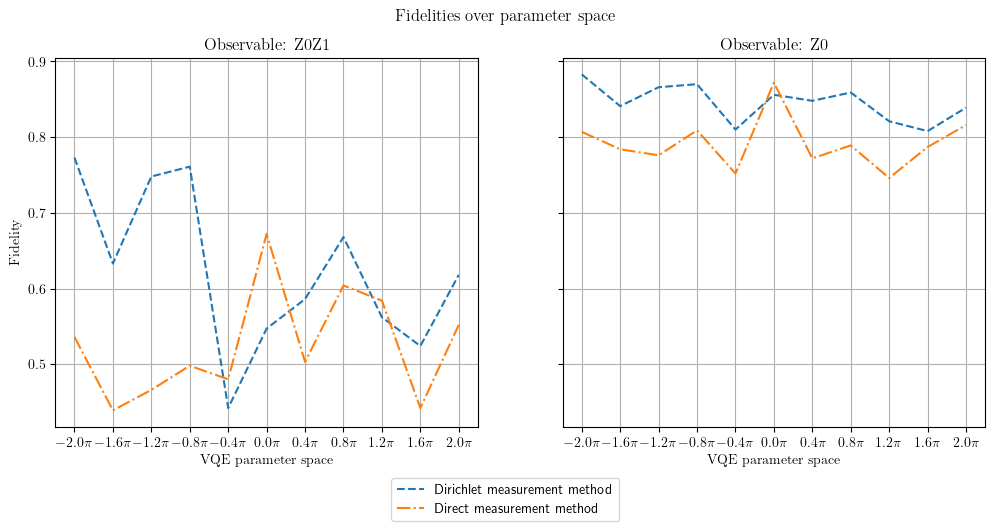

In [84]:
fids=[]

params_sweep_space = np.linspace(-2*np.pi, 2*np.pi, num=len(unique_params_2qb))
params_for_fids=[param for param in params_sweep_space]

fids_for_z0_over_methods={}
fids_for_z0z1_over_methods={}
fids_for_z0_over_params_dirichlet=[]
fids_for_z0_over_params_direct=[]
fids_for_z0z1_over_params_dirichlet=[]
fids_for_z0z1_over_params_direct=[]

for idx, param in enumerate(unique_params_2qb):
    #print(param)
    param_mask=vpe_data_2qb['parameter'].apply(lambda x: all(val is None or val in param for val in x) if x is not None else False)
    cached_param_mask=vpe_data_2qb['cached_params'].apply(lambda x: all(val is None or val in param for val in x) if x is not None else False)
    #param_filt=vpe_data[vpe_data['parameter']==param]
    param_filt=vpe_data_2qb[param_mask]
    #cached_param_filt=vpe_data[vpe_data['cached_params']==param]
    cached_param_filt=vpe_data_2qb[cached_param_mask]
    for method in param_filt['expval_method'].dropna().unique():
        #method='dirichlet'
        method_filt=param_filt[param_filt['expval_method']==method]
        cached_method_filt=cached_param_filt[cached_param_filt['expval_method']==method]
        for obs in method_filt['observable'].dropna().unique():
            #phase_func_imag_dev[obs]=method_filt[method_filt['observable']==obs].cfvpe_phase_function_imag_arr.to_numpy()[0]
            phase_func_imag_analytic[obs]=method_filt[method_filt['observable']==obs].cfvpe_ref_phase_function_imag_arr.to_numpy()[0]

            cached_obs_filt=cached_method_filt[cached_method_filt['observable']==obs]
            mask=cached_obs_filt[cached_obs_filt['cached_value_str']=='expvalYphased_ps']
            fidelities[obs]=np.round(cached_obs_filt[cached_obs_filt['cached_value_str']=='fidelity'].cached_value.to_numpy()[0], 3)
            fids.append(fidelities[obs])

        #print('fidelities:',fidelities)
        fids_for_z0_over_methods[method]=fidelities[unique_obs_2qb[0]]
        fids_for_z0z1_over_methods[method]=fidelities[unique_obs_2qb[1]]
    fids_for_z0_over_params_dirichlet.append(fids_for_z0_over_methods['dirichlet'])
    fids_for_z0_over_params_direct.append(fids_for_z0_over_methods['direct'])
    fids_for_z0z1_over_params_dirichlet.append(fids_for_z0z1_over_methods['dirichlet'])
    fids_for_z0z1_over_params_direct.append(fids_for_z0z1_over_methods['direct'])


fig_dirichlet, (ax1, ax2) = plt.subplots(1,2, sharey=True)

ax1.plot(params_for_fids, fids_for_z0_over_params_dirichlet, linestyle="--", label="Dirichlet measurement method")
ax1.plot(params_for_fids, fids_for_z0_over_params_direct, linestyle="-.", label="Direct measurement method")
ax1.set_xlabel(r'$\textrm{VQE parameter space}$')
ax1.set_ylabel(r'$\textrm{Fidelity}$')
ax1.set_title(r'$\textrm{Observable: Z0Z1}$')
assert '1.0 [Z0 Z1]'==unique_obs_2qb[0]

pi_formatter = lambda x: r"${}\pi$".format(np.round(x / np.pi,2))
tick_labels = [pi_formatter(x) for x in params_for_fids]
ax1.set_xticks(params_for_fids, tick_labels)
ax1.grid(True)

ax2.plot(params_for_fids, fids_for_z0z1_over_params_dirichlet, linestyle="--")
ax2.plot(params_for_fids, fids_for_z0z1_over_params_direct, linestyle="-.")
ax2.set_xlabel(r'$\textrm{VQE parameter space}$')
ax2.set_title(r'$\textrm{Observable: Z0}$')
assert '1.0 [Z0]'==unique_obs_2qb[1]
ax2.set_xticks(params_for_fids, tick_labels)
ax2.grid(True)

fig_dirichlet.legend(bbox_to_anchor=(0.5, -0.1), loc='outside lower center')
fig_dirichlet.suptitle(r'$\textrm{Fidelities over parameter space}$')
fig_dirichlet.set_figwidth(12)

#fig_dirichlet.show()
from pathlib import Path
figures_filename= notebook_path+'/fidelities_2qubits/'+'/fidelities_2qubits.pdf'
Path(figures_filename).parent.mkdir(parents=True, exist_ok=True)
plt.savefig(figures_filename)
#fig_dirichlet.legend(loc='outside lower center')
plt.show()

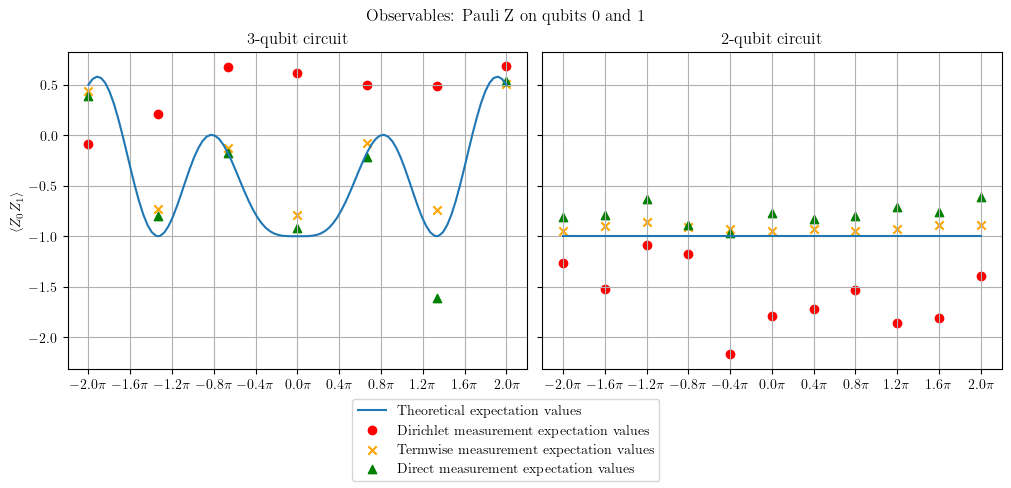

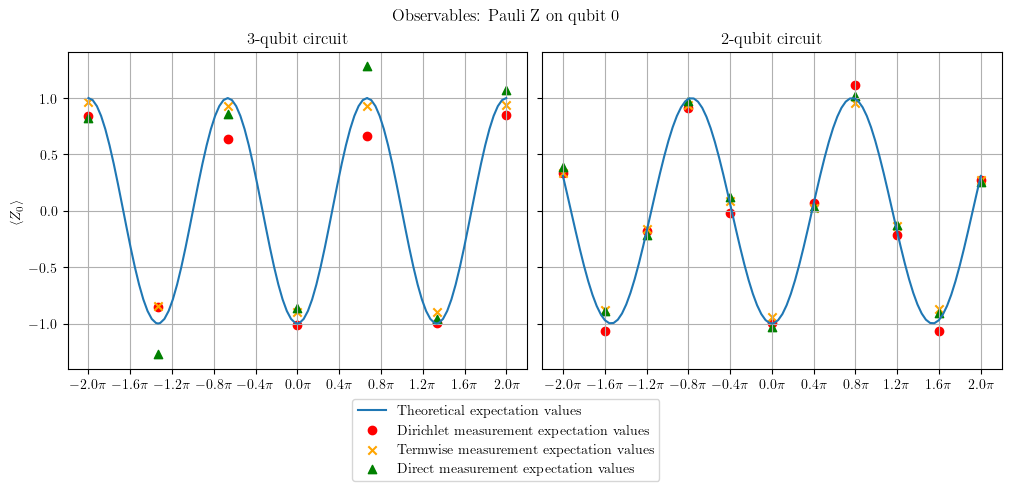

In [91]:
from pathlib import Path

#for expval_meth in vpe_data.expval_method.dropna().unique():
for obs in vpe_data_3qb.observable.dropna().unique():
    dirichlet_data_3qb=vpe_data_3qb[(vpe_data_3qb['expval_method']==vpe_data_3qb.expval_method.dropna().unique()[0]) & (vpe_data_3qb['observable']==obs)]
    direct_data_3qb=vpe_data_3qb[(vpe_data_3qb['expval_method']==vpe_data_3qb.expval_method.dropna().unique()[1]) & (vpe_data_3qb['observable']==obs)]
    dirichlet_vpe_expvals_3qb=dirichlet_data_3qb['cfvpe_expvals'].dropna()
    direct_vpe_expvals_3qb=direct_data_3qb['cfvpe_expvals'].dropna()
    termwise_expvals_3qb=direct_data_3qb['termwise_expvals'].dropna() #termwise expectation values are the same for both data sets
    #expvals_list[str(expval_meth+'_'+obs)]=expvals
    params_3qb=direct_data_3qb['parameter'].dropna() #the evaluation of the expectation 
    #pars[str(expval_meth+'_'+obs)]=params
    param_sweep_space_3qb = np.linspace(-2*np.pi, 2*np.pi, num=len(params_3qb))
    an_param_sweep_space_3qb = np.linspace(-2*np.pi, 2*np.pi, num=100)
    an_param_sweep_space_3qb = sorted([*param_sweep_space_3qb, *an_param_sweep_space_3qb])
    an_expvals_3qb=[circ2(x, obs) for x in an_param_sweep_space_3qb]

    dirichlet_data_2qb=vpe_data_2qb[(vpe_data_2qb['expval_method']==vpe_data_2qb.expval_method.dropna().unique()[0]) & (vpe_data_2qb['observable']==obs)]
    direct_data_2qb=vpe_data_2qb[(vpe_data_2qb['expval_method']==vpe_data_2qb.expval_method.dropna().unique()[1]) & (vpe_data_2qb['observable']==obs)]
    dirichlet_vpe_expvals_2qb=dirichlet_data_2qb['cfvpe_expvals'].dropna()
    direct_vpe_expvals_2qb=direct_data_2qb['cfvpe_expvals'].dropna()
    termwise_expvals_2qb=direct_data_2qb['termwise_expvals'].dropna() #termwise expectation values are the same for both data sets
    #expvals_list[str(expval_meth+'_'+obs)]=expvals
    params_2qb=direct_data_2qb['parameter'].dropna() #the evaluation of the expectation 
    #pars[str(expval_meth+'_'+obs)]=params
    param_sweep_space_2qb = np.linspace(-2*np.pi, 2*np.pi, num=len(params_2qb))
    an_param_sweep_space_2qb = np.linspace(-2*np.pi, 2*np.pi, num=100)
    an_param_sweep_space_2qb = sorted([*param_sweep_space_2qb, *an_param_sweep_space_2qb])
    an_expvals_2qb=[circ(x, obs) for x in an_param_sweep_space_2qb]

    fig1, ((ax1, ax2)) = plt.subplots(1,2,  layout='constrained',sharey=True, sharex=True)
    ax1.plot(an_param_sweep_space_3qb,an_expvals_3qb, linestyle='-',label=r'$\textrm{Theoretical expectation values}$')
    ax1.scatter(param_sweep_space_3qb, dirichlet_vpe_expvals_3qb, color='red', marker='o', label=r'$\textrm{Dirichlet measurement expectation values}$')
    ax1.set_title(r'$\textrm{3-qubit circuit}$')
    ax1.scatter(param_sweep_space_3qb, termwise_expvals_3qb, color='orange', marker='x', label=r'$\textrm{Termwise measurement expectation values}$')# label='Measured expectation values')
    ax1.scatter(param_sweep_space_3qb, direct_vpe_expvals_3qb, color='green', marker='^', label=r'$\textrm{Direct measurement expectation values}$')

    ax2.plot(an_param_sweep_space_2qb,an_expvals_2qb, linestyle='-')#,label=r'$\textrm{Theoretical expectation values}$')
    ax2.scatter(param_sweep_space_2qb, dirichlet_vpe_expvals_2qb, color='red', marker='o')#, label=r'$\textrm{Dirichlet measurement expectation values}$')
    ax2.set_title(r'$\textrm{2-qubit circuit}$')
    ax2.scatter(param_sweep_space_2qb, termwise_expvals_2qb, color='orange', marker='x')#, label=r'$\textrm{Termwise measurement expectation values}$')# label='Measured expectation values')
    ax2.scatter(param_sweep_space_2qb, direct_vpe_expvals_2qb, color='green', marker='^')#, label=r'$\textrm{Direct measurement expectation values}$')

    ax1.grid(True)
    ax2.grid(True)
    fig1.legend(loc='outside lower center')
    if obs=='1.0 [Z0]':
        fig1.suptitle(r'$\textrm{Observables: Pauli Z on qubit 0}$')
        ax1.set_ylabel(r'$\langle Z_0 \rangle $')
        #ax3.set_ylabel(r'$\langle Z_0 \rangle $')
    else:
        fig1.suptitle(r'$\textrm{Observables: Pauli Z on qubits 0 and 1}$')
        ax1.set_ylabel(r'$\langle Z_0 Z_1 \rangle $')
        #ax3.set_ylabel(r'$\langle Z_0 Z_1 \rangle $')
    #custom ticks
    pi_formatter = lambda x: r"${}\pi$".format(np.round(x / np.pi,1))
    tick_labels_3qb = [pi_formatter(x) for x in param_sweep_space_3qb]
    ax1.set_xticks(param_sweep_space_3qb, tick_labels_3qb)

    tick_labels_2qb = [pi_formatter(x) for x in param_sweep_space_2qb]
    ax2.set_xticks(param_sweep_space_2qb, tick_labels_2qb)

    figures_filename= notebook_path+'/experiment_expvals_2x1_2and3qubits/'+'/obs_'+str(obs)+'.pdf'
    Path(figures_filename).parent.mkdir(parents=True, exist_ok=True)
    fig1.set_figwidth(10)
    plt.savefig(figures_filename)
    plt.show()
    #plt.clf()

    


[-9.4247779608, 4.1908845999]
{'1.0 [Z0 Z1]': 0.64, '1.0 [Z0]': 0.7}


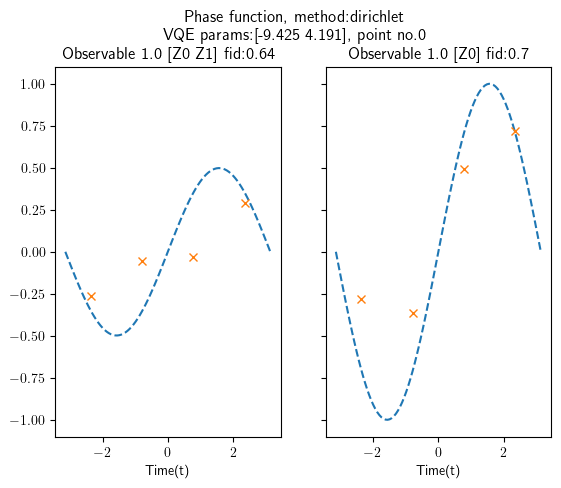

{'1.0 [Z0 Z1]': 0.623, '1.0 [Z0]': 0.679}


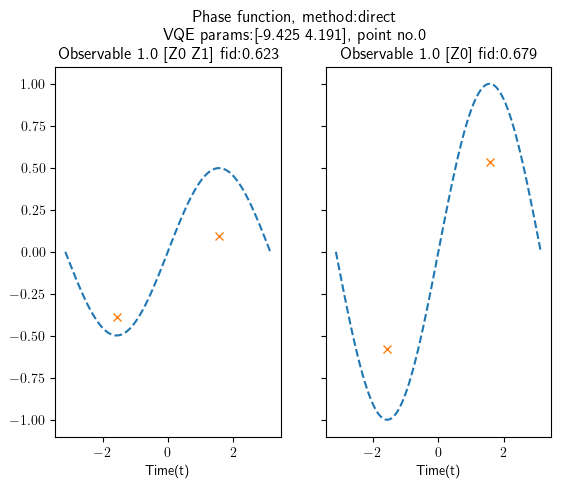

[-6.2831853072, 2.7939230666]
{'1.0 [Z0 Z1]': 0.562, '1.0 [Z0]': 0.675}


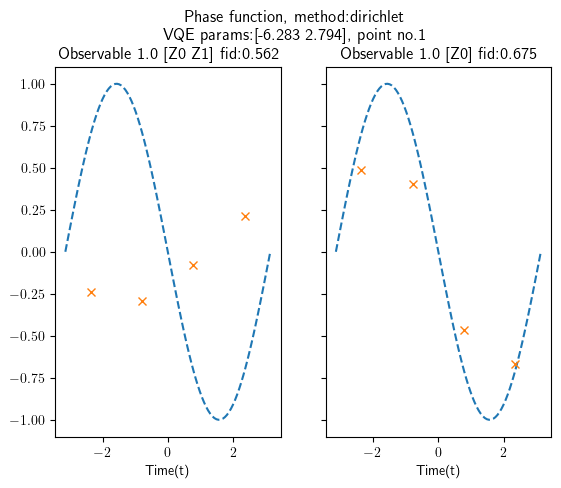

{'1.0 [Z0 Z1]': 0.505, '1.0 [Z0]': 0.514}


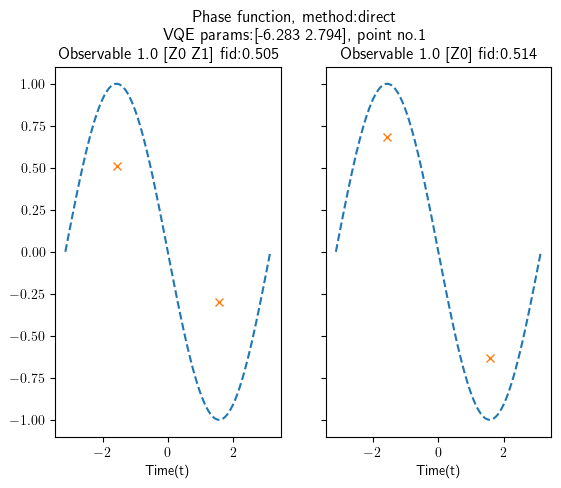

[-3.1415926536, 1.3969615333]
{'1.0 [Z0 Z1]': 0.64, '1.0 [Z0]': 0.605}


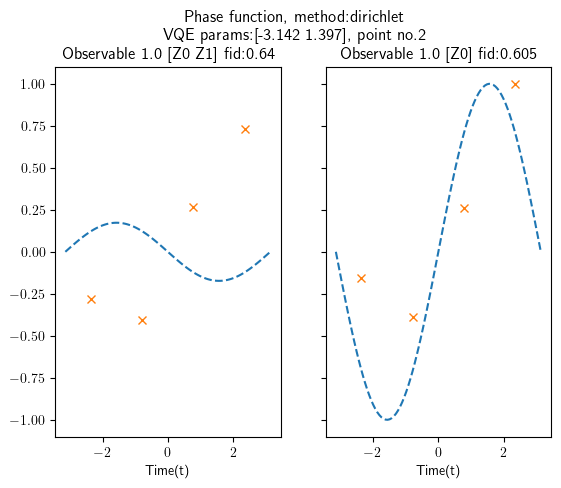

{'1.0 [Z0 Z1]': 0.644, '1.0 [Z0]': 0.64}


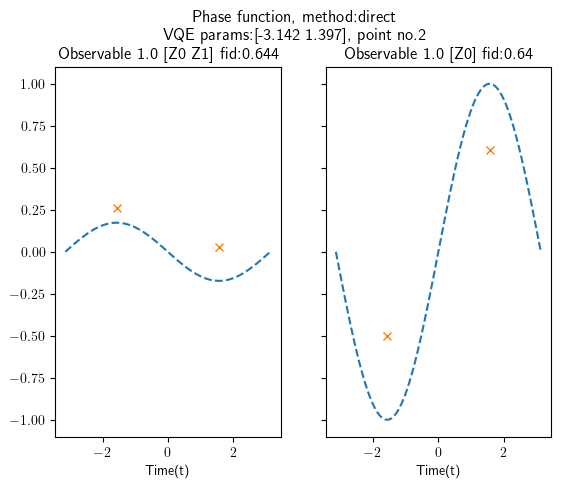

[0.0, 0.0]
{'1.0 [Z0 Z1]': 0.532, '1.0 [Z0]': 0.888}


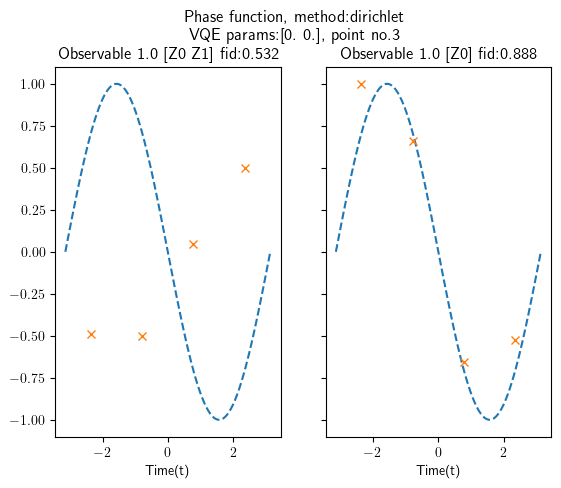

{'1.0 [Z0 Z1]': 0.655, '1.0 [Z0]': 0.887}


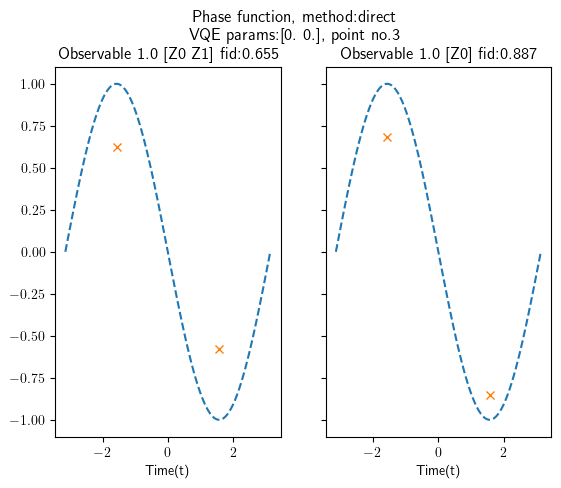

[3.1415926536, -1.3969615333]
{'1.0 [Z0 Z1]': 0.541, '1.0 [Z0]': 0.695}


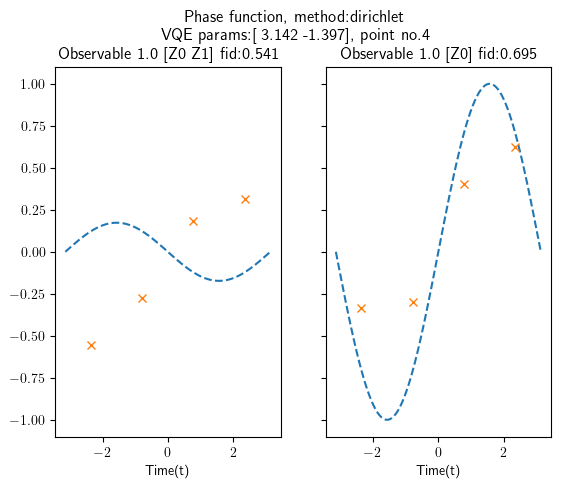

{'1.0 [Z0 Z1]': 0.513, '1.0 [Z0]': 0.65}


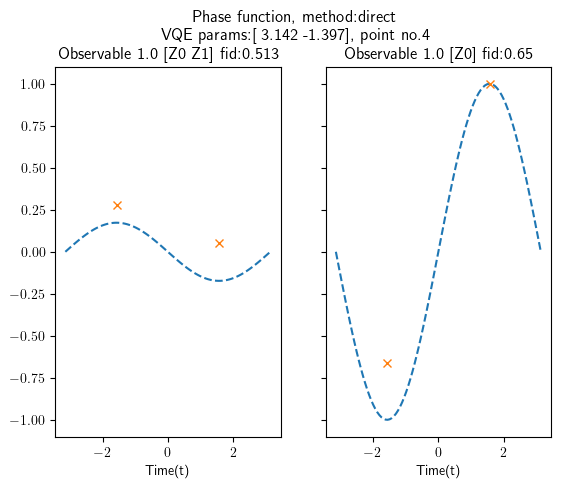

[6.2831853072, -2.7939230666]
{'1.0 [Z0 Z1]': 0.399, '1.0 [Z0]': 0.7}


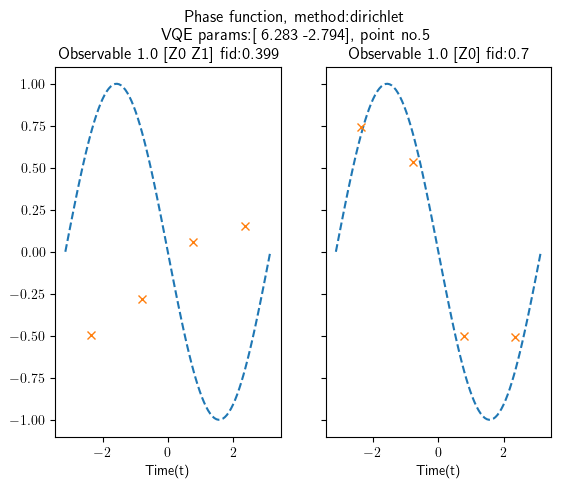

{'1.0 [Z0 Z1]': 0.392, '1.0 [Z0]': 0.702}


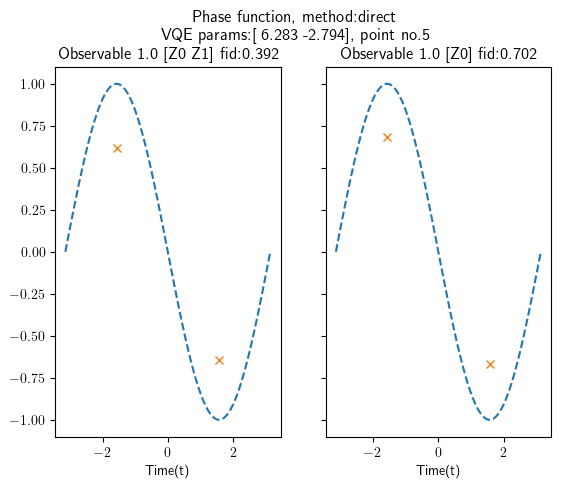

[9.4247779608, -4.1908845999]
{'1.0 [Z0 Z1]': 0.51, '1.0 [Z0]': 0.561}


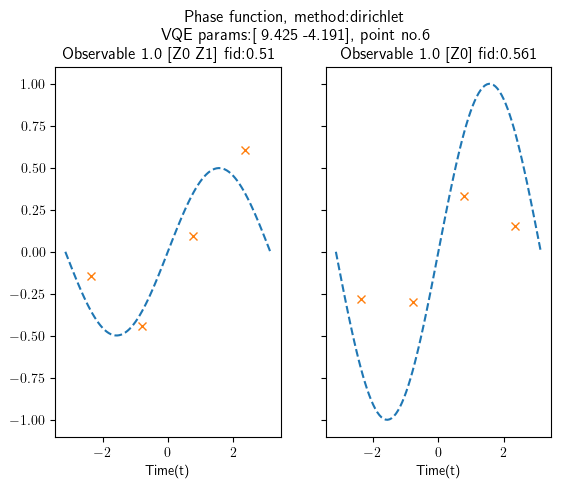

{'1.0 [Z0 Z1]': 0.612, '1.0 [Z0]': 0.633}


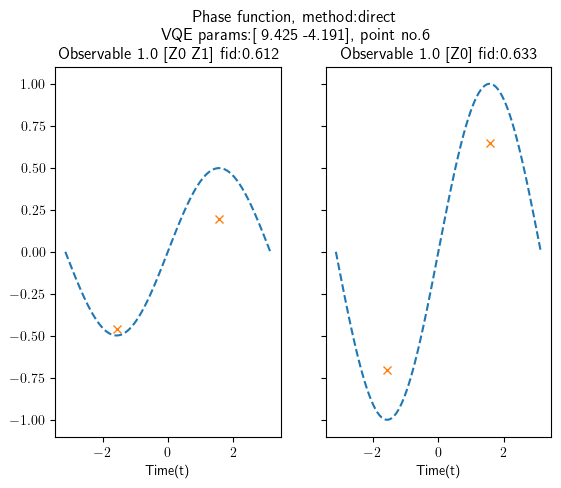

In [92]:
phase_func_imag_dev={}
phase_func_imag_analytic={}
vpe_expvals={}
vpe_expvals_times={}
fidelities={}

num_linspace_points_analytic = 100
an_times= np.linspace(-np.pi, np.pi, num=num_linspace_points_analytic)

for idx, param in enumerate(unique_params_3qb):
    print(param)
    param_mask=vpe_data_3qb['parameter'].apply(lambda x: all(val is None or val in param for val in x) if x is not None else False)
    cached_param_mask=vpe_data_3qb['cached_params'].apply(lambda x: all(val is None or val in param for val in x) if x is not None else False)
    param_filt=vpe_data_3qb[param_mask]
    #param_filt=vpe_data[vpe_data['parameter']==param]
    #cached_param_filt=vpe_data[vpe_data['cached_params']==param]
    cached_param_filt=vpe_data_3qb[cached_param_mask]
    for method in param_filt['expval_method'].dropna().unique():
        #method='dirichlet'
        method_filt=param_filt[param_filt['expval_method']==method]
        cached_method_filt=cached_param_filt[cached_param_filt['expval_method']==method]
        for obs in method_filt['observable'].dropna().unique():
            #phase_func_imag_dev[obs]=method_filt[method_filt['observable']==obs].cfvpe_phase_function_imag_arr.to_numpy()[0]
            phase_func_imag_analytic[obs]=method_filt[method_filt['observable']==obs].cfvpe_ref_phase_function_imag_arr.to_numpy()[0]
            cached_obs_filt=cached_method_filt[cached_method_filt['observable']==obs]
            mask=cached_obs_filt[cached_obs_filt['cached_value_str']=='expvalYphased_ps']
            fidelities[obs]=np.round(cached_obs_filt[cached_obs_filt['cached_value_str']=='fidelity'].cached_value.to_numpy()[0], 3)
            for time in mask.cached_time.unique():
                vpe_expvals[obs]=mask.cached_value.to_numpy()
                vpe_expvals_times[obs]=mask.cached_time.to_numpy()
        print(fidelities)
        fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
        
        ax1.plot(an_times, phase_func_imag_analytic[unique_obs_3qb[0]], linestyle='--')
        ax1.plot(vpe_expvals_times[unique_obs_3qb[0]], vpe_expvals[unique_obs_3qb[0]], 'x')
        ax1.set_title('Observable '+unique_obs_3qb[0]+ ' fid:'+str(fidelities[unique_obs_3qb[0]]))
        ax1.set_xlabel('Time(t)')
        
        ax2.plot(an_times, phase_func_imag_analytic[unique_obs_3qb[1]], linestyle='--')
        ax2.plot(vpe_expvals_times[unique_obs_3qb[1]], vpe_expvals[unique_obs_3qb[1]], 'x')
        ax2.set_title('Observable '+unique_obs_3qb[1]+' fid:'+str(fidelities[unique_obs_3qb[1]]))
        ax2.set_xlabel('Time(t)')
        
        fig.suptitle('Phase function, method:'+str(method)+'\n VQE params:'+str(np.round(param,3))+', point no.'+str(idx),y=1.)
        from pathlib import Path
        out_path=notebook_path+"/mainz_phase_fn_plots_3qubits/"+'phase_fn_'+str(method)+str(np.round(param,3))+'no_'+str(idx)+'.pdf'
        Path(out_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(out_path)
        plt.show()

## temp device data

In [318]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
#import openfermion as of
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import covvqetools as cov

plt.rcParams.update({
  "text.usetex": True,
  #"font.family": "Helvetica"
})

notebook_path = os.path.dirname(os.path.realpath("__file__"))
#data_dir1 = notebook_path+'/optimizer_plot_data/optimizer_many_gens/rg_nact6/'
vpe_data_path1 = notebook_path+'/mainz_cost_model/vpe_experimental_data/data_caching_v35_redtrap/'
vpe_data_path2 = notebook_path+'/mainz_cost_model/vpe_experimental_data/data_caching_v38/'

vpe_data = pd.read_json(vpe_data_path1+'/all_data.json')
vpe_data2= pd.read_json(vpe_data_path2+'/all_data.json')

In [320]:
import pennylane as qml
import covvqetools as cov
import openfermion as of

def ansatz(params, wires=range(2)):
    qml.PauliX(wires=[0])
    qml.SingleExcitation(params, wires=[0, 1])
Method = cov.ControlFreeVPE & cov.Termwise
dev_ref = qml.device('default.qubit', shots=None, wires=2)

def cfvpe_phase_function_callable(param, expval_method, observable):
    vpe = Method(observable=observable, expval_method=expval_method, use_vpe_cache=True, fake_term_groups_via_hermitian=False, dev=dev_ref)
    return vpe.term_group_spectral_properties(param, ansatz=ansatz, dev=dev_ref)[-1]

def dev_times(row):
    return np.array(np.linspace(-np.pi, np.pi, num=11))

def an_times(row):
    a=np.array(np.linspace(-np.pi, np.pi, num=11))
    b=np.array(np.linspace(-np.pi, np.pi, num=100))
    
    return sorted([*a, *b])

def apply_phase_function_imag_dev(row):
    entry_observable=of.QubitOperator('Z0', 1.0) if row['observable']=='1.0 [Z0]' else of.QubitOperator('Z0 Z1', 1.0) 
    entry_param=row['parameter']
    entry_exp_val=row['expval_method']
    fnc=cfvpe_phase_function_callable(entry_param, entry_exp_val, entry_observable)
    return [np.imag(fnc(0,time)) for time in np.array(np.linspace(-np.pi, np.pi, num=11))]

def apply_phase_function_real_dev(row):
    entry_observable=of.QubitOperator('Z0', 1.0) if row['observable']=='1.0 [Z0]' else of.QubitOperator('Z0 Z1', 1.0) 
    entry_param=row['parameter']
    entry_exp_val=row['expval_method']
    fnc=cfvpe_phase_function_callable(entry_param, entry_exp_val, entry_observable)
    return [np.real(fnc(0,time)) for time in np.array(np.linspace(-np.pi, np.pi, num=11))]

def apply_phase_function_imag_an(row):
    entry_observable=of.QubitOperator('Z0', 1.0) if row['observable']=='1.0 [Z0]' else of.QubitOperator('Z0 Z1', 1.0) 
    entry_param=row['parameter']
    entry_exp_val=row['expval_method']
    fnc=cfvpe_phase_function_callable(entry_param, entry_exp_val, entry_observable)
    a=np.array(np.linspace(-np.pi, np.pi, num=11))
    b=np.array(np.linspace(-np.pi, np.pi, num=100))
    times = sorted([*a, *b])
    return [np.imag(fnc(0,time)) for time in times]

def apply_phase_function_real_an(row):
    entry_observable=of.QubitOperator('Z0', 1.0) if row['observable']=='1.0 [Z0]' else of.QubitOperator('Z0 Z1', 1.0) 
    entry_param=row['parameter']
    entry_exp_val=row['expval_method']
    fnc=cfvpe_phase_function_callable(entry_param, entry_exp_val, entry_observable)
    a=np.array(np.linspace(-np.pi, np.pi, num=11))
    b=np.array(np.linspace(-np.pi, np.pi, num=100))
    times = sorted([*a, *b])
    return [np.real(fnc(0,time)) for time in times]

vpe_data['cfvpe_phase_function_imag_arr']=vpe_data.apply(apply_phase_function_imag_dev, axis=1)
vpe_data['cfvpe_phase_function_real_arr']=vpe_data.apply(apply_phase_function_real_dev, axis=1)
vpe_data['cfvpe_ref_phase_function_imag_arr']=vpe_data.apply(apply_phase_function_imag_an, axis=1)
vpe_data['cfvpe_ref_phase_function_real_arr']=vpe_data.apply(apply_phase_function_real_an, axis=1)
vpe_data['device_times']=vpe_data.apply(dev_times, axis=1)
vpe_data['analytic_times']=vpe_data.apply(an_times, axis=1)


/home/cvmxn/covqcstack/hfak/covvqetools/covvqetools/measurement/base.py:3238: UserWarning: Calculating term_group_eig_probs with the fake_term_groups_via_hermitian logic even though fake_term_groups_via_hermitian=False because it cannot currently be calculated without faking term groups.
  warnings.warn(
/home/cvmxn/covqcstack/hfak/covvqetools/covvqetools/measurement/base.py:3169: UserWarning: Found that self.dev.shots is None and thus cannot distribute shots according to the shots of the device. If you want to do shot counting or simulate with shot noise you probably should set shot_distributor=fixed_shots_per_circuit(shots) when initializing the measurement method or via the method's shot_distributor property.
  warnings.warn(
/home/cvmxn/covqcstack/hfak/covvqetools/covvqetools/measurement/base.py:2644: UserWarning: Not actually modifying number of shots as working with an analytic device.
  warnings.warn(
/home/cvmxn/covqcstack/hfak/covvqetools/covvqetools/measurement/base.py:3238: 

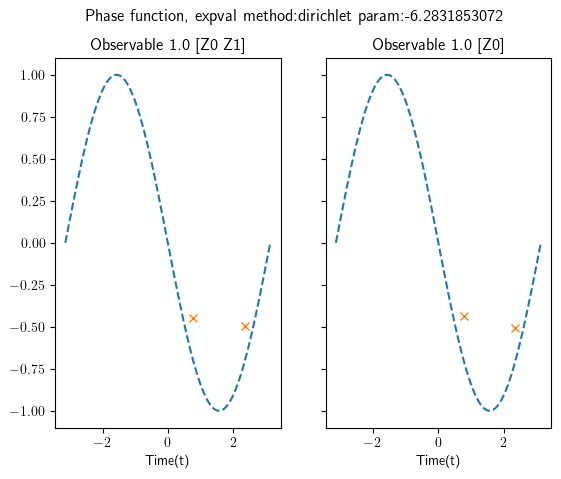

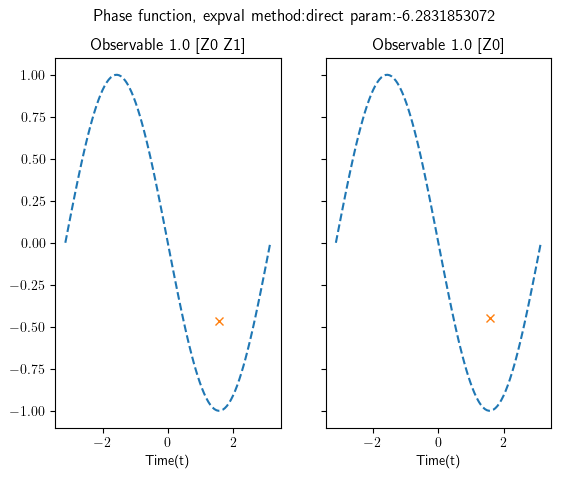

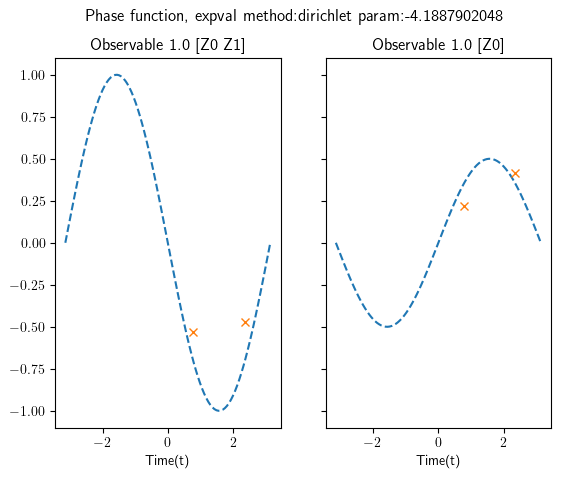

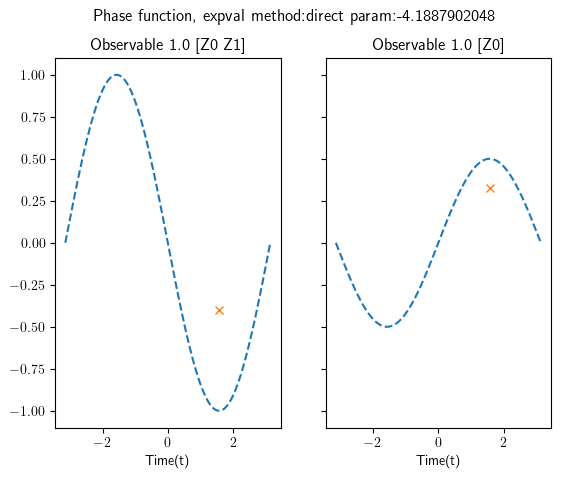

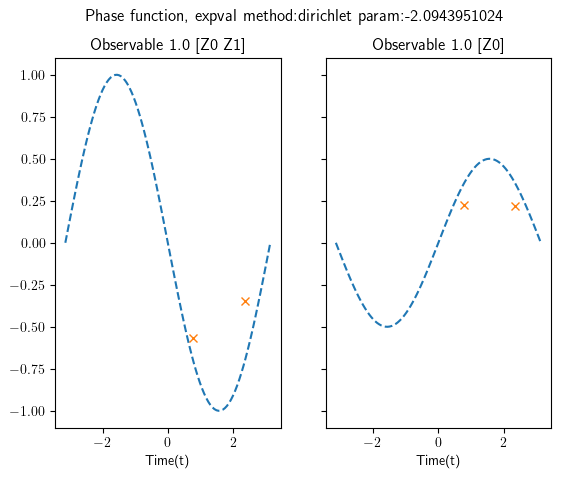

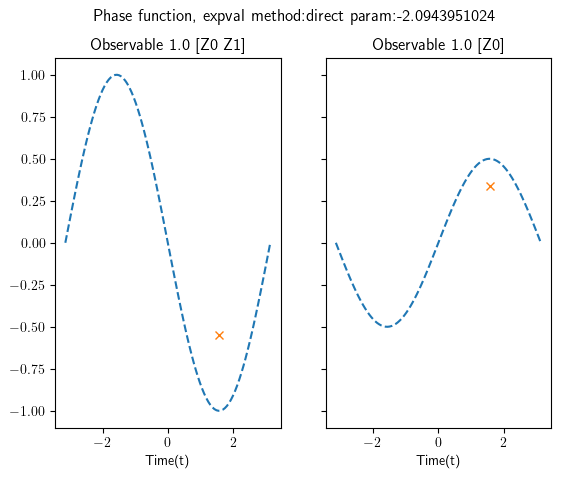

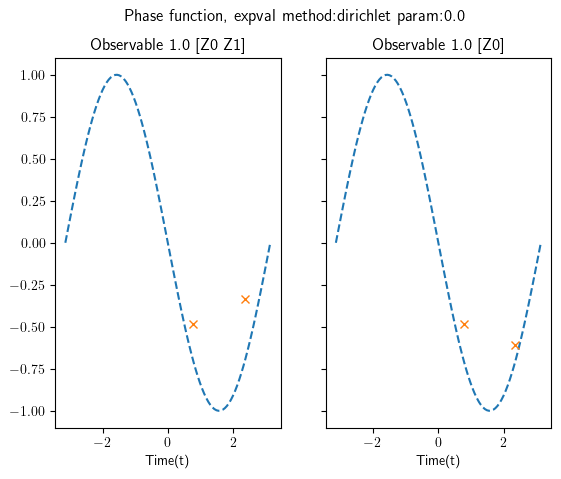

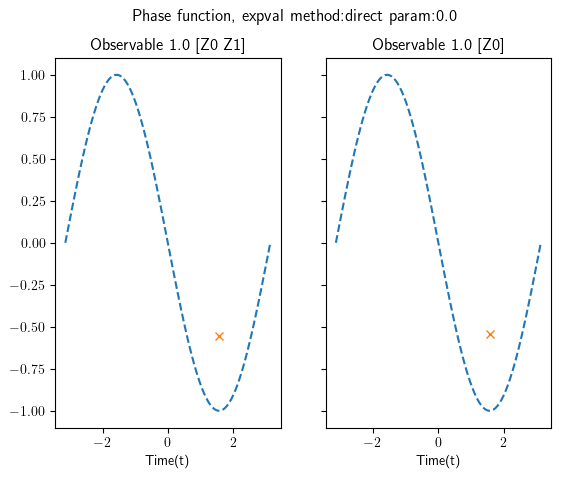

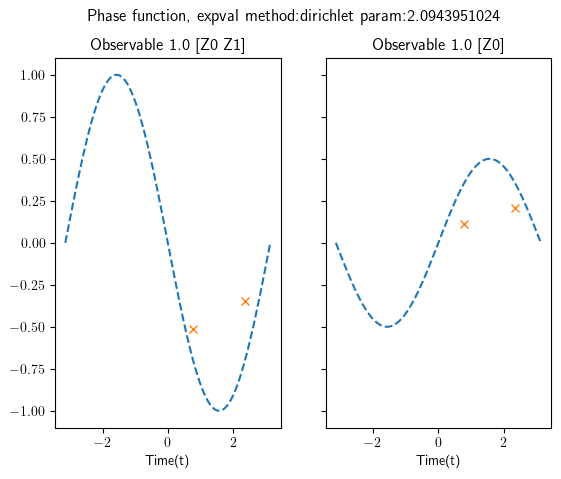

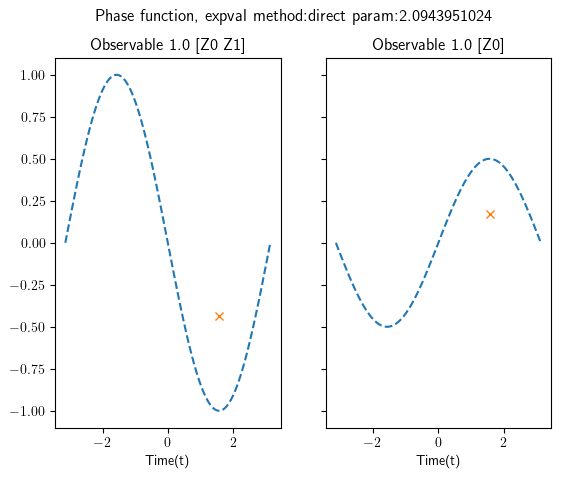

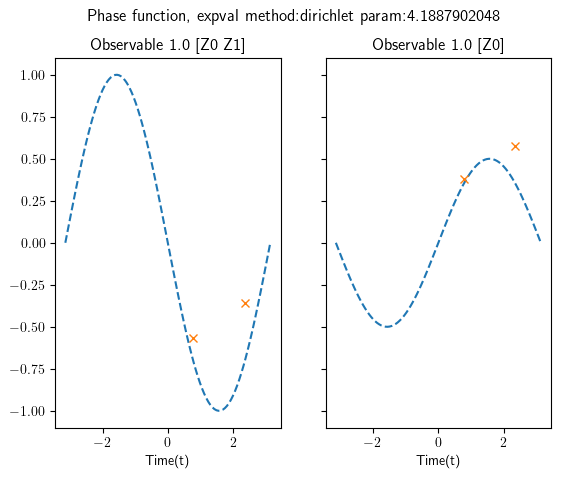

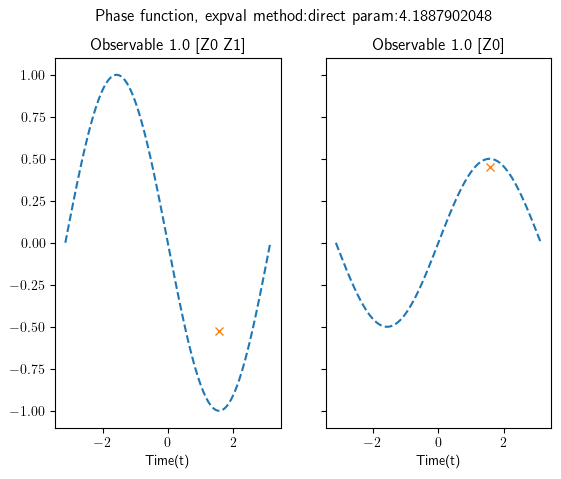

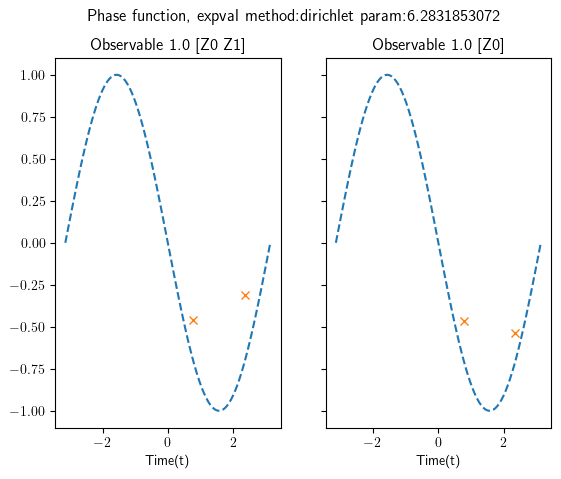

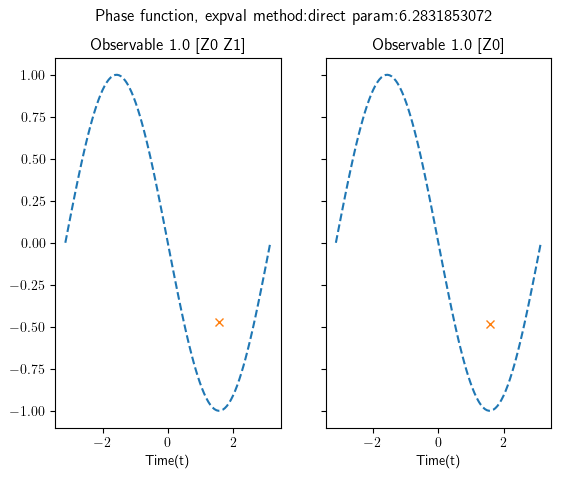

In [362]:
phase_func_imag_dev={}
phase_func_imag_analytic={}
vpe_expvals={}
vpe_expvals_times={}

dev_times=vpe_data.device_times.dropna().to_numpy()[0]
an_times=vpe_data.analytic_times.dropna().to_numpy()[0]

for param in unique_params:
    param_filt=vpe_data[vpe_data['parameter']==param]
    cached_param_filt=vpe_data[vpe_data['cached_params']==param]
    for method in param_filt['expval_method'].dropna().unique():
        #method='dirichlet'
        method_filt=param_filt[param_filt['expval_method']==method]
        cached_method_filt=cached_param_filt[cached_param_filt['expval_method']==method]
        for obs in method_filt['observable'].dropna().unique():
            phase_func_imag_dev[obs]=method_filt[method_filt['observable']==obs].cfvpe_phase_function_imag_arr.to_numpy()[0]
            phase_func_imag_analytic[obs]=method_filt[method_filt['observable']==obs].cfvpe_ref_phase_function_imag_arr.to_numpy()[0]            
            cached_obs_filt=cached_method_filt[cached_method_filt['observable']==obs]
            mask=cached_obs_filt[cached_obs_filt['cached_value_str']=='expvalYphased_ps']
            for time in mask.cached_time.unique():
                vpe_expvals[obs]=mask.cached_value.to_numpy()
                vpe_expvals_times[obs]=mask.cached_time.to_numpy()

        fig, (ax1,ax2) = plt.subplots(1,2, sharey=True)
        ax1.plot(an_times, phase_func_imag_analytic[unique_obs[0]], linestyle='--')
        #ax1.plot(dev_times, phase_func_imag_dev[unique_obs[0]], 'o')
        ax1.plot(vpe_expvals_times[unique_obs[0]], vpe_expvals[unique_obs[0]], 'x')
        ax1.set_title('Observable '+unique_obs[0])
        ax1.set_xlabel('Time(t)')
        ax2.plot(an_times, phase_func_imag_analytic[unique_obs[1]], linestyle='--')
        #ax2.plot(dev_times, phase_func_imag_dev[unique_obs[1]], 'o')
        ax2.plot(vpe_expvals_times[unique_obs[1]], vpe_expvals[unique_obs[1]], 'x')
        ax2.set_title('Observable '+unique_obs[1])
        ax2.set_xlabel('Time(t)')
        fig.suptitle('Phase function, expval method:'+str(method)+' param:'+str(param))
        
        plt.show()

        

In [323]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
#import openfermion as of
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import covvqetools as cov

plt.rcParams.update({
  "text.usetex": True,
  #"font.family": "Helvetica"
})

notebook_path = os.path.dirname(os.path.realpath("__file__"))
#data_dir1 = notebook_path+'/optimizer_plot_data/optimizer_many_gens/rg_nact6/'
vpe_data_path1 = notebook_path+'/mainz_cost_model/vpe_experimental_data/data_caching_v39_redtrap/'
vpe_data_path2 = notebook_path+'/mainz_cost_model/vpe_experimental_data/data_caching_v38/'

vpe_data = pd.read_json(vpe_data_path1+'/all_data.json')
vpe_data2= pd.read_json(vpe_data_path2+'/all_data.json')

In [326]:
vpe_data[vpe_data['cached_value_str']=='fidelity']

,cfvpe_expvals,cfvpe_ref_expvals,termwise_expvals,parameter,observable,cfvpe_phase_function_real_arr,cfvpe_ref_phase_function_real_arr,termwise_phase_function_real_arr,cfvpe_phase_function_imag_arr,cfvpe_ref_phase_function_imag_arr,termwise_phase_function_imag_arr,analytic_times,device_times,expval_method,cfvpe_phase_function_real_var,cfvpe_phase_function_imag_var,termwise_phase_function_real_var,termwise_phase_function_imag_var,cfvpe_ref_phase_function_real_var,cfvpe_ref_phase_function_imag_var,cached_value,cached_shots,cached_weighted_value,cached_value_str,cached_params,cached_time,device_shots,method_name,is_experiment,ref_cached_value,ref_cached_shots,ref_cached_value_str,ref_cached_params,ref_cached_time,ref_observable,ref_device_shots,ref_expval_method,ref_method_name,ref_is_experiment
15,NaN,NaN,NaN,NaN,1.0 [Z0],None,None,None,None,None,None,None,None,dirichlet,None,None,None,None,None,None,1.0,200.0,200.0,fidelity,-6.283185,0.0,400.0,ControlFreeVPE&Termwise,0.0,NaN,None,None,NaN,NaN,None,None,None,None,NaN
24,NaN,NaN,NaN,NaN,1.0 [Z0],None,None,None,None,None,None,None,None,dirichlet,None,None,None,None,None,None,1.0,200.0,200.0,fidelity,-4.188790,0.0,400.0,ControlFreeVPE&Termwise,0.0,NaN,None,None,NaN,NaN,None,None,None,None,NaN
33,NaN,NaN,NaN,NaN,1.0 [Z0],None,None,None,None,None,None,None,None,dirichlet,None,None,None,None,None,None,1.0,200.0,200.0,fidelity,-2.094395,0.0,400.0,ControlFreeVPE&Termwise,0.0,NaN,None,None,NaN,NaN,None,None,None,None,NaN
42,NaN,NaN,NaN,NaN,1.0 [Z0],None,None,None,None,None,None,None,None,dirichlet,None,None,None,None,None,None,1.0,200.0,200.0,fidelity,0.000000,0.0,400.0,ControlFreeVPE&Termwise,0.0,NaN,None,None,NaN,NaN,None,None,None,None,NaN
51,NaN,NaN,NaN,NaN,1.0 [Z0],None,None,None,None,None,None,None,None,dirichlet,None,None,None,None,None,None,1.0,200.0,200.0,fidelity,2.094395,0.0,400.0,ControlFreeVPE&Termwise,0.0,NaN,None,None,NaN,NaN,None,None,None,None,NaN
60,NaN,NaN,NaN,NaN,1.0 [Z0],None,None,None,None,None,None,None,None,dirichlet,None,None,None,None,None,None,1.0,200.0,200.0,fidelity,4.188790,0.0,400.0,ControlFreeVPE&Termwise,0.0,NaN,None,None,NaN,NaN,None,None,None,None,NaN
69,NaN,NaN,NaN,NaN,1.0 [Z0],None,None,None,None,None,None,None,None,dirichlet,None,None,None,None,None,None,1.0,200.0,200.0,fidelity,6.283185,0.0,400.0,ControlFreeVPE&Termwise,0.0,NaN,None,None,NaN,NaN,None,None,None,None,NaN


In [2]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
#import openfermion as of
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import covvqetools as cov

plt.rcParams.update({
  "text.usetex": True,
  #"font.family": "Helvetica"
})

notebook_path = os.path.dirname(os.path.realpath("__file__"))
#data_dir1 = notebook_path+'/optimizer_plot_data/optimizer_many_gens/rg_nact6/'
# vpe_data_path = notebook_path+'/mainz_cost_model/vpe_experimental_data/data_caching_v39/'
vpe_data_path = notebook_path+'/mainz_cost_model/vpe_experimental_data/data_caching_v47_redtrap_2000shots/'
#vpe_data_path = notebook_path+'/mainz_cost_model/vpe_experimental_data/redtrap_many_shots_v35/syste_size_2'
#vpe_data_path = notebook_path+'/mainz_cost_model/vpe_experimental_data/dirichlet_mirroring_v1/'

vpe_data = pd.read_json(vpe_data_path+'/all_data.json')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [5]:
vpe_data[vpe_data['ref_expval_method']=='direct']

,cfvpe_expvals,cfvpe_ref_expvals,termwise_expvals,parameter,observable,cfvpe_phase_function_real_arr,cfvpe_ref_phase_function_real_arr,termwise_phase_function_real_arr,cfvpe_phase_function_imag_arr,cfvpe_ref_phase_function_imag_arr,termwise_phase_function_imag_arr,analytic_times,device_times,expval_method,cfvpe_phase_function_real_var,cfvpe_phase_function_imag_var,termwise_phase_function_real_var,termwise_phase_function_imag_var,cfvpe_ref_phase_function_real_var,cfvpe_ref_phase_function_imag_var,cached_value,cached_shots,cached_weighted_value,cached_value_str,cached_params,cached_time,device_shots,method_name,is_experiment,ref_cached_value,ref_cached_shots,ref_cached_value_str,ref_cached_params,ref_cached_time,ref_observable,ref_device_shots,ref_expval_method,ref_method_name,ref_is_experiment
532,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,None,NaN,NaN,NaN,None,NaN,-1.000000,None,expvalYphased_nops,-6.283185,1.570796,1.0 [Z0],None,direct,ControlFreeVPE&Termwise,1.0
533,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,None,NaN,NaN,NaN,None,NaN,0.000000,None,Yphasedvar_nops,-6.283185,1.570796,1.0 [Z0],None,direct,ControlFreeVPE&Termwise,1.0
534,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,None,NaN,NaN,NaN,None,NaN,-0.991955,None,expvalYphased_nops,-6.156252,1.570796,1.0 [Z0],None,direct,ControlFreeVPE&Termwise,1.0
535,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,None,NaN,NaN,NaN,None,NaN,0.016026,None,Yphasedvar_nops,-6.156252,1.570796,1.0 [Z0],None,direct,ControlFreeVPE&Termwise,1.0
536,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,None,NaN,NaN,NaN,None,NaN,-0.967949,None,expvalYphased_nops,-6.029319,1.570796,1.0 [Z0],None,direct,ControlFreeVPE&Termwise,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,None,NaN,NaN,NaN,None,NaN,0.000000,None,Yphasedvar_nops,6.029319,1.570796,1.0 [Z0 Z1],None,direct,ControlFreeVPE&Termwise,1.0
990,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,None,NaN,NaN,NaN,None,NaN,-1.000000,None,expvalYphased_nops,6.156252,1.570796,1.0 [Z0 Z1],None,direct,ControlFreeVPE&Termwise,1.0
991,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,None,NaN,NaN,NaN,None,NaN,0.000000,None,Yphasedvar_nops,6.156252,1.570796,1.0 [Z0 Z1],None,direct,ControlFreeVPE&Termwise,1.0
992,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,None,NaN,NaN,NaN,None,NaN,-1.000000,None,expvalYphased_nops,6.283185,1.570796,1.0 [Z0 Z1],None,direct,ControlFreeVPE&Termwise,1.0


In [32]:
unique_obs=vpe_data.observable.dropna().unique()
print('before', unique_obs)
unique_obs=[vpe_data.observable.dropna().unique()[0],vpe_data.observable.dropna().unique()[0]]
print('after', unique_obs)

before ['1.0 [Z0 Z1]' '1.0 [Z0]']
after ['1.0 [Z0 Z1]', '1.0 [Z0 Z1]']


In [33]:
len(unique_params)

7

In [34]:
phase_func_imag_dev={}
phase_func_imag_analytic={}
vpe_expvals={}
vpe_expvals_times={}
fidelities={}

num_linspace_points_analytic = 100
an_times= np.linspace(-np.pi, np.pi, num=num_linspace_points_analytic)

params_sweep_space = np.linspace(-2*np.pi, 2*np.pi, num=7)
params_for_expvals=[param for param in params_sweep_space]

for idx, param in enumerate(unique_params):
    print(param)
    param_mask=vpe_data['parameter'].apply(lambda x: all(val is None or val in param for val in x) if x is not None else False)
    cached_param_mask=vpe_data['cached_params'].apply(lambda x: all(val is None or val in param for val in x) if x is not None else False)
    #param_filt=vpe_data[vpe_data['parameter']==param]
    param_filt=vpe_data[param_mask]
    #cached_param_filt=vpe_data[vpe_data['cached_params']==param]
    cached_param_filt=vpe_data[cached_param_mask]
    for method in param_filt['expval_method'].dropna().unique():
        #method='dirichlet'
        method_filt=param_filt[param_filt['expval_method']==method]
        cached_method_filt=cached_param_filt[cached_param_filt['expval_method']==method]
        for obs in method_filt['observable'].dropna().unique():
            #phase_func_imag_dev[obs]=method_filt[method_filt['observable']==obs].cfvpe_phase_function_imag_arr.to_numpy()[0]
            phase_func_imag_analytic[obs]=method_filt[method_filt['observable']==obs].cfvpe_ref_phase_function_imag_arr.to_numpy()[0]
            cached_obs_filt=cached_method_filt[cached_method_filt['observable']==obs]
            mask=cached_obs_filt[cached_obs_filt['cached_value_str']=='expvalYphased_ps']
            fidelities[obs]=np.round(cached_obs_filt[cached_obs_filt['cached_value_str']=='fidelity'].cached_value.to_numpy()[0], 3)
            for time in mask.cached_time.unique():
                vpe_expvals[obs]=mask.cached_value.to_numpy()
                vpe_expvals_times[obs]=mask.cached_time.to_numpy()
        print(fidelities)
        fig, (ax1) = plt.subplots(1,1, sharey=True)
        ax1.plot(an_times, phase_func_imag_analytic[unique_obs[0]], linestyle='--')
        #ax1.plot(dev_times, phase_func_imag_dev[unique_obs[0]], 'o')
        ax1.plot(vpe_expvals_times[unique_obs[0]], vpe_expvals[unique_obs[0]], 'x')
        #ax1.plot(vpe_expvals_times[unique_obs[0]], vpe_expvals[unique_obs[0]]/fidelities[unique_obs[0]], 'o')

        ax1.set_title('Observable '+unique_obs[0]+ ' fid:'+str(fidelities[unique_obs[0]]))
        ax1.set_xlabel('Time(t)')
        fig.suptitle('Phase function, method:'+str(method)+'\n VQE params:'+str(np.round(params_for_expvals[idx],3)),y=1.)
        fig.savefig('phase_fn_'+str(method)+str(np.round(params_for_expvals[idx],3))+'.pdf')
        plt.show()

-6.2831853072


TypeError: 'float' object is not iterable

In [35]:
vpe_data.device_shots.dropna()

7       2000.0
8       2000.0
9       2000.0
10      2000.0
11      2000.0
         ...  
1059    2000.0
1060    2000.0
1061    2000.0
1062    2000.0
1063    2000.0
Name: device_shots, Length: 196, dtype: float64